In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.7 MB/s eta 0:00:00


In [ ]:
import optuna

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import math


import sklearn
import keras
import keras.backend as K
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM, CuDNNLSTM, MaxPooling1D, Conv1D, Flatten, BatchNormalization, Dropout, Input
from tensorflow.keras.layers import Bidirectional
from keras.models import Model
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping


from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from math import sqrt

from joblib import Parallel
from joblib import delayed
from datetime import datetime

#import optuna

from sklearn.preprocessing import StandardScaler

from keras.utils import custom_object_scope
from keras.utils import get_custom_objects
from keras.models import load_model

from keras.layers import LSTM, RepeatVector, TimeDistributed, BatchNormalization, Dropout
from keras.initializers import GlorotUniform
from keras.activations import relu
from joblib import Parallel, delayed

import cProfile

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Multiply, Add
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_probability as tfp
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.optimizers import SGD
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_vwc = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd7_vwc_.npy', allow_pickle=True)
df_stemp = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd7_stemp_.npy', allow_pickle=True)
df_T = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_T.npy', allow_pickle=True)
df_RH = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_RH.npy', allow_pickle=True)
#df_DP = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd7_DP.npy', allow_pickle=True)
df_Rain = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_Rain.npy', allow_pickle=True)
df_WS = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_WS.npy', allow_pickle=True)
#df_WD = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_WD.npy', allow_pickle=True)
df_S = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_S.npy', allow_pickle=True)

list_ = [df_vwc, df_Rain, df_stemp, df_T, df_RH,  df_WS, df_S]

# IMF = np.empty((10, 10, 10))
IMFs = [[],[],[],[],[],[],[],[],[]]
# for i in list_:
#   print(i.shape)
for k in range(len(IMFs)):
  for i in list_:
    IMFs[k].append(i[k])

dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])

data1 = pd.DataFrame(IMFs[0]).T
data2 = pd.DataFrame(IMFs[1]).T
data3 = pd.DataFrame(IMFs[2]).T

data = data1 + data2 + data3

data.columns = ['S7_Top_VWC_Avg','Rain','S7_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']

index = pd.DataFrame(dataset.index)

df = pd.concat([index, data], axis = 1)
df = df.set_index('Date Time')

In [4]:
def split_dataset(data):
  """
    Splits the dataset into train and test sets.

    Args:
        data (array): The dataset to be split.

    Returns:
        train (array): The training dataset.
        test (array): The testing dataset.
  """
  # split into standard weeks
  train, test = data[1:-6046], data[-6048:]
  #train, test = data[:-5817], data[-5817:-57] 6048
  # restructure into windows of weekly data
  train = np.array(np.split(train, len(train)/144))
  test = np.array(np.split( test , len(test )/144))
  return train, test

def to_supervised(train, n_input, n_out=144):
  #flattern data
  data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for i in range(len(data)):
    #define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    #ensure there is enough data
    if out_end <= len(data):
      X.append(data[in_start:in_end, :])
      y.append(data[in_end:out_end, 0])
    # move along one time step
    in_start += 1
  return np.array(X), np.array(y)

def build_moe_model_with_autoencoder_cnn_attention(input_dim, output_dim, expert_hidden_sizes, expert_output_sizes,
                                     gating_hidden_sizes, num_experts, learning_rate, activation, kernel_initializer, dropout_rate,
                                     num_iterations=2):
    """
    Builds a Mixture of Experts (MoE) model with autoencoder, CNN and attention mechanisms.

    Args:
        input_dim (int): The dimension of input features.
        output_dim (int): The dimension of output features.
        expert_hidden_sizes (list): The hidden layer sizes for each expert.
        expert_output_sizes (list): The output layer sizes for each expert.
        gating_hidden_sizes (list): The hidden layer sizes for the gating network.
        num_experts (int): The number of experts in the model.
        learning_rate (float): The learning rate for the optimizer.
        activation (str): The activation function to be used in the hidden layers.
        kernel_initializer (str): The kernel initializer for the layers.
        dropout_rate (float): The dropout rate for dropout layers.
        num_iterations (int, optional): The number of iterations for training. Defaults to 100.

    Returns:
        moe_model (Model): The Mixture of Experts model.
        experts (list): The list of expert models.
        gating_model (Model): The gating network model.
    """
    experts = []
    for i in range(num_experts):
        if i == 0:  # Replace first expert with an autoencoder
            expert_input = Input(shape=(input_dim))
            expert_hidden = Dense(expert_hidden_sizes[i], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
            expert_hidden = Dropout(dropout_rate)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for LSTM input
            expert_hidden, _, _ = LSTM(expert_hidden_sizes[i], return_state=True, kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
            expert_hidden = Multiply()([expert_hidden, attention])
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))
        elif i == 1:  # Replace second expert with a Transformer expert
            expert_input = Input(shape=(input_dim))
            expert_hidden = Dense(expert_hidden_sizes[i], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
            expert_hidden = Dropout(dropout_rate)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for Transformer input
            expert_hidden = MultiHeadAttention(num_heads=8, key_dim=expert_hidden_sizes[i])(expert_hidden, expert_hidden)
            expert_hidden = Flatten()(expert_hidden)
            attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
            expert_hidden = Multiply()([expert_hidden, attention])
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))
        else:  # Replace third expert with a GRU-based model
            expert_input = Input(shape=(input_dim))
            expert_hidden = Dense(expert_hidden_sizes[i], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
            expert_hidden = Dropout(dropout_rate)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for GRU input
            expert_hidden, _ = GRU(expert_hidden_sizes[i], return_state=True, kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
            expert_hidden = Multiply()([expert_hidden, attention])
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))

    # Define the gating network
    gating_input = Input(shape=(input_dim,))
    gating_hidden = Dense(gating_hidden_sizes[0], activation='relu', kernel_initializer='he_normal')(gating_input)
    gating_hidden = Dropout(dropout_rate)(gating_hidden)
    gating_hidden = tf.expand_dims(gating_hidden, axis=1)  # Expand dimensions for LSTM input
    gating_hidden = Bidirectional(LSTM(gating_hidden_sizes[1], return_sequences=False, kernel_initializer='he_normal'))(gating_hidden)

    gating_output = Dense(num_experts + num_experts * 2, activation=None, kernel_initializer='he_normal')(gating_hidden)

    logits = gating_output[:, :num_experts]
    params = gating_output[:, num_experts:]
    params = tf.reshape(params, [-1, num_experts, 2])

    gating_distribution = tfp.distributions.MixtureSameFamily(
        mixture_distribution=tfp.distributions.Categorical(logits=logits),
        components_distribution=tfp.distributions.Normal(
            loc=params[..., 0],
            scale=tf.math.softplus(params[..., 1])
        )
    )

    gating_model = Model(inputs=gating_input, outputs=logits)

    # Define the MoE model
    inputs = Input(shape=(input_dim,))
    outputs = []
    for i in range(num_experts):
        expert_output = experts[i](inputs)
        if i == 0:  # For the autoencoder expert, append encoded representation to outputs list
            outputs.append(expert_output)
        else:
            outputs.append(experts[i](inputs))

    gating_output = gating_model(inputs)
    weighted_outputs = [tf.expand_dims(gating_output[:, i], axis=-1) * expert_output[:, :1] for i, expert_output in enumerate(outputs)]

    outputs = tf.reduce_sum(weighted_outputs, axis=0)

    moe_model = Model(inputs=inputs, outputs=outputs)

    return moe_model, experts, gating_model

# Define the loss function
def moe_loss(y_true, y_pred, gating_output):
    """
    Defines the loss function for the Mixture of Experts (MoE) model.

    Args:
        y_true (tensor): The true target values.
        y_pred (tensor): The predicted target values.
        gating_output (tensor): The output of the gating network.

    Returns:
        (tensor): The calculated MoE loss.
    """
    y_true = tf.cast(y_true, y_pred.dtype)

    # Compute MAE instead of MSE
    expert_losses = tf.reduce_mean(tf.abs(y_true - y_pred), axis=-1)
    expert_losses = tf.expand_dims(expert_losses, axis=-1)

    # Apply softmax to the logits to get probabilities
    gating_probabilities = tf.nn.softmax(gating_output, axis=-1)

    # Multiply expert_losses with the gating probabilities
    gating_losses = tf.reduce_sum(tf.multiply(expert_losses, gating_probabilities), axis=-1)

    return tf.reduce_mean(gating_losses)
def mae_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def nmse_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    variance = tf.math.reduce_variance(y_true)
    return mse / variance

def smape_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)
  denominator = (tf.abs(y_true) + tf.abs(y_pred)) + 1e-8
  return 2 * tf.reduce_mean(tf.abs(y_true - y_pred) / denominator)


def scheduler(epoch, lr):
    """
    Custom learning rate scheduler.

    Args:
        epoch (int): The current epoch.
        lr (float): The current learning rate.

    Returns:
        (float): The updated learning rate.
    """
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def sliding_window_split(data, window_size, step_size):
    """
    Splits the input data into sliding windows of specified size and step size.

    Args:
        data (array): The input data to be split.
        window_size (int): The size of the sliding window.
        step_size (int): The step size for sliding the window.

    Returns:
        windowed_data (list): A list of arrays containing the data split into sliding windows.
    """
    windowed_data = []
    for i in range(0, len(data) - window_size, step_size):
        windowed_data.append(data[i:i + window_size])
    return windowed_data
import os

def save_best_model_callback(study, trial):
    if study.best_trial.number == trial.number:
        # Save the best model
        best_model = trial.user_attrs['model']
        model_path = f'/content/drive/Shareddrives/1st Paper/best_MoE_model_S7_{trial.number}.h5'
        best_model.save(model_path)
        print(f"Best model saved to {model_path}")

In [5]:
def objective(trial, train_input, train_output, input_dim, output_dim):
    """ Objective function for hyper-paramter tuning. Read README file for further specifications.
    """
    # Define the hyperparameters to optimize using Optuna
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    activation = trial.suggest_categorical('activation', ['relu', 'sigmoid', 'tanh'])
    kernel_initializer = trial.suggest_categorical('kernel_initializer', ['glorot_normal', 'he_normal', None])

    window_size = 500
    step_size = 50

    # Define the sizes of the hidden layers for each expert
    expert_hidden_sizes = [16, 32, 64]

    # Define the sizes of the output layers for each expert
    expert_output_sizes = [144,144,144]

    # Define the sizes of the gating network hidden layers
    gating_hidden_sizes = [16, 8]

    # Define the size of the output layer of the gating network
    gating_output_size = num_experts

    # Define the number of training iterations for the EM algorithm
    num_iterations = 2 #change to 10

    df2 = df.copy()
    scaler = StandardScaler()

    # Fit and transform the data in the DataFrame
    standardized_data = scaler.fit_transform(df2)

    # Convert the result back to a DataFrame with the original column names
    s_df = pd.DataFrame(standardized_data, columns=df2.columns)
    train, test = split_dataset(df.values)
    s_train, s_test = split_dataset(s_df.values)
    #train = (train - np.mean(train, axis=0)) / np.std(train, axis=0)
    train_input_windows, _ = to_supervised(s_train, 144)

    _, train_output_windows = to_supervised(train, 144)
    train_output_windows = np.array([[item] for item in train_output_windows[:][:]])
    train_output_windows = train_output_windows.reshape(train_output_windows.shape[0],train_output_windows.shape[2], train_output_windows.shape[1])



    # Build and train the model using the hyperparameters
    moe_model, experts, gating_model = build_moe_model_with_autoencoder_cnn_attention(
        input_dim,
        output_dim,
        expert_hidden_sizes,
        expert_output_sizes,
        gating_hidden_sizes,
        num_experts,
        learning_rate,
        activation,
        kernel_initializer,
        dropout_rate)

    # Define the optimization algorithm
    optimizer = Adam(learning_rate=learning_rate)

    # Learning rate scheduler
    lr_scheduler = LearningRateScheduler(scheduler)

    # Train the MoE model with the EM algorithm
    iteration = 0
    while iteration < num_iterations:
        num_train_windows = int(0.8 * len(train_input_windows))
        total_train_loss = 0
        total_val_loss = 0
        for window_idx in range(len(train_input_windows)):

          # E step: Compute the responsibilities of each expert for each data point
          gating_output = tf.constant(gating_model.predict(train_input_windows[window_idx,:,:]), dtype=tf.float64)
          gating_output /= tf.reduce_sum(gating_output, axis=-1, keepdims=True) + 1e-8  # Add a small epsilon value

          # M step: Update the parameters of each expert and the gating network
          for i in range(num_experts):
              expert_input = train_input_windows[window_idx,:,:]
              expert_output = experts[i](expert_input)
              expert_loss = tf.reduce_mean(tf.square(train_output_windows[window_idx,:,:] - expert_output), axis=-1)

              with tf.GradientTape() as tape:
                  # Watch the trainable variables of the expert model
                  tape.watch(experts[i].trainable_variables)

                  # Define the expert model and calculate the expert_loss
                  expert_output = experts[i](expert_input)
                  expert_loss = tf.reduce_mean(tf.square(train_output_windows[window_idx,:,:] - expert_output), axis=-1)

              # Compute the gradients
              expert_gradient = tape.gradient(expert_loss, experts[i].trainable_variables)
              # Clip gradients for expert models
              expert_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in expert_gradient]

              # Update the variables
              optimizer.apply_gradients(zip(expert_gradient, experts[i].trainable_variables))

          current_learning_rate = scheduler(iteration, optimizer.learning_rate.numpy())
          optimizer.learning_rate.assign(current_learning_rate)

          gating_input = train_input_windows[window_idx,:,:]

          with tf.GradientTape() as tape:
              # Watch the trainable variables of the gating model
              tape.watch(gating_model.trainable_variables)

              # Define the gating model and calculate the gating_loss
              gating_output = gating_model(gating_input)
              gating_loss = moe_loss(tf.constant(train_output_windows[window_idx,:,:], dtype=tf.float32), moe_model(train_input_windows[window_idx,:,:]), gating_output)


          # Compute the gradients
          gating_gradient = tape.gradient(gating_loss, gating_model.trainable_variables)
          # Clip gradients for the gating model
          gating_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gating_gradient]

          # Update the variables
          optimizer.apply_gradients(zip(gating_gradient, gating_model.trainable_variables))

          # Evaluate the performance of the MoE model on the training set
          if window_idx < num_train_windows:
            train_loss = moe_loss(train_output_windows[window_idx], moe_model.predict(train_input_windows[window_idx]), gating_model.predict(train_input_windows[window_idx]))
            total_train_loss += train_loss
            print(f'Iteration {iteration + 1}, Training window {window_idx + 1}: Training loss = {train_loss:.6f}')
            train_mse = mse_loss(train_output_windows[window_idx], moe_model.predict(train_input_windows[window_idx]))
            train_nmse = nmse_loss(train_output_windows[window_idx], moe_model.predict(train_input_windows[window_idx]))
            train_smape = smape_loss(train_output_windows[window_idx], moe_model.predict(train_input_windows[window_idx]))

          else:
            val_loss = moe_loss(train_output_windows[window_idx], moe_model.predict(train_input_windows[window_idx]), gating_model.predict(train_input_windows[window_idx]))
            total_val_loss += val_loss
            print(f'Iteration {iteration + 1}, Validation window {window_idx - num_train_windows + 1}: Validation loss = {val_loss:.6f}')
            val_mse = mse_loss(train_output_windows[window_idx], moe_model.predict(train_input_windows[window_idx]))
            val_nmse = nmse_loss(train_output_windows[window_idx], moe_model.predict(train_input_windows[window_idx]))
            val_smape = smape_loss(train_output_windows[window_idx], moe_model.predict(train_input_windows[window_idx]))


        # Stop training if the learning rate becomes too small
        if current_learning_rate < 1e-6:
            print('Learning rate dropped below 1e-6 after iteration %d' % iteration)
            break

        iteration += 1
    trial.set_user_attr('model', moe_model)
    trial.set_user_attr('train_mse', train_mse)
    trial.set_user_attr('train_nmse', train_nmse)
    trial.set_user_attr('train_smape', train_smape)


    # Calculating the average train and validation loss
    avg_train_loss = total_train_loss / num_train_windows
    avg_val_loss = total_val_loss / (len(train_input_windows) - num_train_windows)


    # Store all the metrics you want to track
    trial.set_user_attr('train_mse', train_mse)
    trial.set_user_attr('train_nmse', train_nmse)
    trial.set_user_attr('train_smape', train_smape)
    trial.set_user_attr('avg_train_loss', avg_train_loss)
    trial.set_user_attr('avg_val_loss', avg_val_loss)
    trial.set_user_attr('val_mse', val_mse)
    trial.set_user_attr('val_nmse', val_nmse)
    trial.set_user_attr('val_smape', val_smape)

    # Return only the metric you're optimizing
    return avg_val_loss



In [6]:
def split_dataset(data):
  """
    Splits the dataset into train and test sets.

    Args:
        data (array): The dataset to be split.

    Returns:
        train (array): The training dataset.
        test (array): The testing dataset.
  """
  # split into standard weeks
  #train, test = data[1:6769], data[6769:6769+(144*8)]
  train, test = data[1:2881], data[2881:2881+(144*8)]
  #train, test = data[:-5817], data[-5817:-57] 6048
  # restructure into windows of weekly data
  train = np.array(np.split(train, len(train)/144))
  test = np.array(np.split( test , len(test )/144))
  return train, test

def save_best_model_callback(study, trial):
  if study.best_trial.number == trial.number:
      # Save the best model
      best_model = trial.user_attrs['model']
      model_path = f'/content/drive/Shareddrives/1st Paper/best_MoE_model_S7_eemd123-{trial.number}.h5'
      best_model.save(model_path)
      print(f"Best model saved to {model_path}")

dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])

data1 = pd.DataFrame(IMFs[0]).T
data2 = pd.DataFrame(IMFs[1]).T
data3 = pd.DataFrame(IMFs[2]).T

data = data1 + data2 + data3

data.columns = ['S7_Top_VWC_Avg','Rain','S7_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']

index = pd.DataFrame(dataset.index)

df = pd.concat([index, data], axis = 1)
df = df.set_index('Date Time')

In [ ]:
from functools import partial



train_data = np.array(df.head(10000))
# Split the training data into input and output sequences
train_input = train_data[:, :]
print('train_input shape', train_input.shape)
train_output = train_data[:, -1:]
print('train_output shape', train_output.shape)


# Normalize input data
train_input = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)

input_dim = df.shape[1]
output_dim = 1


df2 = df.copy()
scaler = StandardScaler()

# Fit and transform the data in the DataFrame
standardized_data = scaler.fit_transform(df2)

# Convert the result back to a DataFrame with the original column names
s_df = pd.DataFrame(standardized_data, columns=df2.columns)
train, test = split_dataset(df.values)
s_train, s_test = split_dataset(s_df.values)
#train = (train - np.mean(train, axis=0)) / np.std(train, axis=0)
train_input_windows, _ = to_supervised(s_train, 144)

_, train_output_windows = to_supervised(train, 144)
train_output_windows = np.array([[item] for item in train_output_windows[:][:]])
train_output_windows = train_output_windows.reshape(train_output_windows.shape[0],train_output_windows.shape[2], train_output_windows.shape[1])

# Define the number of experts
num_experts = 3
objective_with_args = partial(objective, train_input=train_input, train_output=train_output, input_dim=input_dim, output_dim=output_dim)
study = optuna.create_study(direction="minimize")

study.optimize(objective_with_args, n_trials=2, callbacks=[save_best_model_callback]) #change to 5

completed_trials = study.trials_dataframe(attrs=('number', 'value', 'params', 'user_attrs'))
print(completed_trials[['number', 'value', 'user_attrs_train_mse', 'user_attrs_train_nmse', 'user_attrs_train_smape',
                        'user_attrs_avg_train_loss', 'user_attrs_avg_val_loss', 'user_attrs_val_mse', 'user_attrs_val_nmse', 'user_attrs_val_smape']])

[I 2023-08-16 03:20:06,171] A new study created in memory with name: no-name-5977bab3-7de7-40dc-8705-5cba397f36ae


Streaming output truncated to the last 5000 lines.
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1880: Training loss = 0.182277
5/5 [==============================] - 0s 3ms/step
Iteration 2, Training window 1881: Training loss = 0.180050
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1882: Training loss = 0.175098
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1883: Training loss = 0.180228
5/5 [==============================] - 0s 3ms/step
Iteration 2, Training window 1884: Training loss = 0.185908
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1885: Training loss = 0.190092
5/5 [==============================] - 0s 3ms/step
Iteration 2, Training window 1886: Training loss = 0.186103
5/5 [==============================] - 0s 3ms/step
Iteration 2, Training window 1887: Training loss = 0.182583
5/5 [==============================] - 0s 3ms/step
Iteration 

[I 2023-08-16 04:18:25,954] Trial 0 finished with value: 0.24966198205947876 and parameters: {'dropout_rate': 0.4660605481276431, 'learning_rate': 0.00583696708116912, 'activation': 'sigmoid', 'kernel_initializer': None}. Best is trial 0 with value: 0.24966198205947876.


Streaming output truncated to the last 5000 lines.
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1880: Training loss = 0.401740
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1881: Training loss = 0.404555
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1882: Training loss = 0.404319
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1883: Training loss = 0.406109
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1884: Training loss = 0.402710
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1885: Training loss = 0.409826
5/5 [==============================] - 0s 5ms/step
Iteration 2, Training window 1886: Training loss = 0.410012
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1887: Training loss = 0.408377
5/5 [==============================] - 0s 2ms/step
Iteration 

[I 2023-08-16 05:16:01,001] Trial 1 finished with value: 0.4858422875404358 and parameters: {'dropout_rate': 0.33972453221361454, 'learning_rate': 0.00014104315154938603, 'activation': 'tanh', 'kernel_initializer': 'he_normal'}. Best is trial 0 with value: 0.24966198205947876.


   number     value                               user_attrs_train_mse  \
0       0  0.249662  tf.Tensor(0.12828476546915768, shape=(), dtype...   
1       1  0.485842  tf.Tensor(0.4101793201311044, shape=(), dtype=...   

                               user_attrs_train_nmse  \
0  tf.Tensor(0.29742715511385315, shape=(), dtype...   
1  tf.Tensor(0.9509973208974668, shape=(), dtype=...   

                          user_attrs_train_smape  \
0  tf.Tensor(0.7566689, shape=(), dtype=float32)   
1  tf.Tensor(1.6464734, shape=(), dtype=float32)   

                       user_attrs_avg_train_loss  \
0  tf.Tensor(0.2548216, shape=(), dtype=float32)   
1  tf.Tensor(0.4615059, shape=(), dtype=float32)   

                          user_attrs_avg_val_loss  \
0  tf.Tensor(0.24966198, shape=(), dtype=float32)   
1   tf.Tensor(0.4858423, shape=(), dtype=float32)   

                                  user_attrs_val_mse  \
0  tf.Tensor(0.08957456404070062, shape=(), dtype...   
1  tf.Tensor(0.2841299

In [ ]:
completed_trials = study.trials_dataframe(attrs=('number', 'value', 'params', 'user_attrs'))
print(completed_trials[['number', 'value', 'user_attrs_train_mse', 'user_attrs_train_nmse', 'user_attrs_train_smape',
                        'user_attrs_avg_train_loss', 'user_attrs_avg_val_loss', 'user_attrs_val_mse', 'user_attrs_val_nmse', 'user_attrs_val_smape']])

**EEMD 456**

In [ ]:
def split_dataset(data):
  """
    Splits the dataset into train and test sets.

    Args:
        data (array): The dataset to be split.

    Returns:
        train (array): The training dataset.
        test (array): The testing dataset.
  """
  # split into standard weeks
  #train, test = data[1:6769], data[6769:6769+(144*8)]
  train, test = data[1:2881], data[2881:2881+(144*4)]
  #train, test = data[:-5817], data[-5817:-57] 6048
  # restructure into windows of weekly data
  train = np.array(np.split(train, len(train)/144))
  test = np.array(np.split( test , len(test )/144))
  return train, test

def save_best_model_callback(study, trial):
  if study.best_trial.number == trial.number:
      # Save the best model
      best_model = trial.user_attrs['model']
      model_path = f'/content/drive/Shareddrives/1st Paper/best_MoE_model_S7_eemd456-_{trial.number}.h5'
      best_model.save(model_path)
      print(f"Best model saved to {model_path}")

dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])

data1 = pd.DataFrame(IMFs[4]).T
data2 = pd.DataFrame(IMFs[5]).T
data3 = pd.DataFrame(IMFs[6]).T

data = data1 + data2 + data3

data.columns = ['S7_Top_VWC_Avg','Rain','S7_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']

index = pd.DataFrame(dataset.index)

df = pd.concat([index, data], axis = 1)
df = df.set_index('Date Time')

from functools import partial



train_data = np.array(df.head(10000))
# Split the training data into input and output sequences
train_input = train_data[:, :]
print('train_input shape', train_input.shape)
train_output = train_data[:, -1:]
print('train_output shape', train_output.shape)


# Normalize input data
train_input = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)

input_dim = df.shape[1]
output_dim = 1


df2 = df.copy()
scaler = StandardScaler()

# Fit and transform the data in the DataFrame
standardized_data = scaler.fit_transform(df2)

# Convert the result back to a DataFrame with the original column names
s_df = pd.DataFrame(standardized_data, columns=df2.columns)
train, test = split_dataset(df.values)
s_train, s_test = split_dataset(s_df.values)
#train = (train - np.mean(train, axis=0)) / np.std(train, axis=0)
train_input_windows, _ = to_supervised(s_train, 144)

_, train_output_windows = to_supervised(train, 144)
train_output_windows = np.array([[item] for item in train_output_windows[:][:]])
train_output_windows = train_output_windows.reshape(train_output_windows.shape[0],train_output_windows.shape[2], train_output_windows.shape[1])

# Define the number of experts
num_experts = 3
objective_with_args = partial(objective, train_input=train_input, train_output=train_output, input_dim=input_dim, output_dim=output_dim)
study = optuna.create_study(direction="minimize")

study.optimize(objective_with_args, n_trials=2, callbacks=[save_best_model_callback]) #change to 5

completed_trials = study.trials_dataframe(attrs=('number', 'value', 'params', 'user_attrs'))
print(completed_trials[['number', 'value', 'user_attrs_train_mse', 'user_attrs_train_nmse', 'user_attrs_train_smape',
                        'user_attrs_avg_train_loss', 'user_attrs_avg_val_loss', 'user_attrs_val_mse', 'user_attrs_val_nmse', 'user_attrs_val_smape']])

[I 2023-08-16 05:16:04,970] A new study created in memory with name: no-name-b2eeadd3-333b-488a-aaa6-670c3f7d1ae1


Streaming output truncated to the last 5000 lines.
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1880: Training loss = 0.146478
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1881: Training loss = 0.145428
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1882: Training loss = 0.144647
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1883: Training loss = 0.144210
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1884: Training loss = 0.144308
5/5 [==============================] - 0s 3ms/step
Iteration 2, Training window 1885: Training loss = 0.145068
5/5 [==============================] - 0s 3ms/step
Iteration 2, Training window 1886: Training loss = 0.146600
5/5 [==============================] - 0s 3ms/step
Iteration 2, Training window 1887: Training loss = 0.148892
5/5 [==============================] - 0s 3ms/step
Iteration 

[I 2023-08-16 06:13:54,511] Trial 0 finished with value: 0.22649523615837097 and parameters: {'dropout_rate': 0.023897319575097553, 'learning_rate': 4.0136868960236486e-05, 'activation': 'tanh', 'kernel_initializer': 'glorot_normal'}. Best is trial 0 with value: 0.22649523615837097.


Streaming output truncated to the last 5000 lines.
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1880: Training loss = 0.181191
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1881: Training loss = 0.179603
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1882: Training loss = 0.178129
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1883: Training loss = 0.176971
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1884: Training loss = 0.176182
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1885: Training loss = 0.175869
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1886: Training loss = 0.176025
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1887: Training loss = 0.176672
5/5 [==============================] - 0s 2ms/step
Iteration 

[I 2023-08-16 07:11:31,207] Trial 1 finished with value: 0.23070982098579407 and parameters: {'dropout_rate': 0.28564825476343336, 'learning_rate': 4.277968929214378e-05, 'activation': 'sigmoid', 'kernel_initializer': None}. Best is trial 0 with value: 0.22649523615837097.


   number     value                               user_attrs_train_mse  \
0       0  0.226495  tf.Tensor(0.02261090891324243, shape=(), dtype...   
1       1  0.230710  tf.Tensor(0.028057617643848985, shape=(), dtyp...   

                               user_attrs_train_nmse  \
0  tf.Tensor(0.47329196622058406, shape=(), dtype...   
1  tf.Tensor(0.5873025747472418, shape=(), dtype=...   

                          user_attrs_train_smape  \
0  tf.Tensor(0.9414601, shape=(), dtype=float32)   
1  tf.Tensor(0.9398789, shape=(), dtype=float32)   

                        user_attrs_avg_train_loss  \
0  tf.Tensor(0.51116353, shape=(), dtype=float32)   
1   tf.Tensor(0.5257422, shape=(), dtype=float32)   

                          user_attrs_avg_val_loss  \
0  tf.Tensor(0.22649524, shape=(), dtype=float32)   
1  tf.Tensor(0.23070982, shape=(), dtype=float32)   

                                  user_attrs_val_mse  \
0  tf.Tensor(0.03307271685304309, shape=(), dtype...   
1  tf.Tensor(0.0519

**EEMD 789**

In [ ]:
def split_dataset(data):
  """
    Splits the dataset into train and test sets.

    Args:
        data (array): The dataset to be split.

    Returns:
        train (array): The training dataset.
        test (array): The testing dataset.
  """
  # split into standard weeks
  #train, test = data[1:6769], data[6769:6769+(144*8)]
  train, test = data[1:2881], data[2881:2881+(144*4)]
  #train, test = data[:-5817], data[-5817:-57] 6048
  # restructure into windows of weekly data
  train = np.array(np.split(train, len(train)/144))
  test = np.array(np.split( test , len(test )/144))
  return train, test

def save_best_model_callback(study, trial):
  if study.best_trial.number == trial.number:
      # Save the best model
      best_model = trial.user_attrs['model']
      model_path = f'/content/drive/Shareddrives/1st Paper/best_MoE_model_S7_eemd789-_{trial.number}.h5'
      best_model.save(model_path)
      print(f"Best model saved to {model_path}")

dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])

data1 = pd.DataFrame(IMFs[7]).T
data2 = pd.DataFrame(IMFs[8]).T


data = data1 + data2

data.columns = ['S7_Top_VWC_Avg','Rain','S7_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']

index = pd.DataFrame(dataset.index)

df = pd.concat([index, data], axis = 1)
df = df.set_index('Date Time')

from functools import partial



train_data = np.array(df.head(10000))
# Split the training data into input and output sequences
train_input = train_data[:, :]
print('train_input shape', train_input.shape)
train_output = train_data[:, -1:]
print('train_output shape', train_output.shape)


# Normalize input data
train_input = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)

input_dim = df.shape[1]
output_dim = 1


df2 = df.copy()
scaler = StandardScaler()

# Fit and transform the data in the DataFrame
standardized_data = scaler.fit_transform(df2)

# Convert the result back to a DataFrame with the original column names
s_df = pd.DataFrame(standardized_data, columns=df2.columns)
train, test = split_dataset(df.values)
s_train, s_test = split_dataset(s_df.values)
#train = (train - np.mean(train, axis=0)) / np.std(train, axis=0)
train_input_windows, _ = to_supervised(s_train, 144)

_, train_output_windows = to_supervised(train, 144)
train_output_windows = np.array([[item] for item in train_output_windows[:][:]])
train_output_windows = train_output_windows.reshape(train_output_windows.shape[0],train_output_windows.shape[2], train_output_windows.shape[1])

# Define the number of experts
num_experts = 3
objective_with_args = partial(objective, train_input=train_input, train_output=train_output, input_dim=input_dim, output_dim=output_dim)
study = optuna.create_study(direction="minimize")

study.optimize(objective_with_args, n_trials=2, callbacks=[save_best_model_callback]) #change to 5

completed_trials = study.trials_dataframe(attrs=('number', 'value', 'params', 'user_attrs'))
print(completed_trials[['number', 'value', 'user_attrs_train_mse', 'user_attrs_train_nmse', 'user_attrs_train_smape',
                        'user_attrs_avg_train_loss', 'user_attrs_avg_val_loss', 'user_attrs_val_mse', 'user_attrs_val_nmse', 'user_attrs_val_smape']])

[I 2023-08-16 12:28:46,204] A new study created in memory with name: no-name-8668ca57-3c68-4fc8-965d-c296f8114a37


Streaming output truncated to the last 5000 lines.
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1880: Training loss = 0.024410
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1881: Training loss = 0.067120
5/5 [==============================] - 0s 3ms/step
Iteration 2, Training window 1882: Training loss = 0.076689
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1883: Training loss = 0.021303
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1884: Training loss = 0.032046
5/5 [==============================] - 0s 3ms/step
Iteration 2, Training window 1885: Training loss = 0.021622
5/5 [==============================] - 0s 3ms/step
Iteration 2, Training window 1886: Training loss = 0.023741
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1887: Training loss = 0.024314
5/5 [==============================] - 0s 2ms/step
Iteration 

[I 2023-08-16 13:28:07,702] Trial 0 finished with value: 0.06705854833126068 and parameters: {'dropout_rate': 0.2869509028887468, 'learning_rate': 0.003032141228309511, 'activation': 'relu', 'kernel_initializer': None}. Best is trial 0 with value: 0.06705854833126068.


Streaming output truncated to the last 5000 lines.
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1880: Training loss = 0.165665
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1881: Training loss = 0.166794
5/5 [==============================] - 0s 3ms/step
Iteration 2, Training window 1882: Training loss = 0.167911
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1883: Training loss = 0.168979
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1884: Training loss = 0.170011
5/5 [==============================] - 0s 3ms/step
Iteration 2, Training window 1885: Training loss = 0.171039
5/5 [==============================] - 0s 2ms/step
Iteration 2, Training window 1886: Training loss = 0.172073
5/5 [==============================] - 0s 3ms/step
Iteration 2, Training window 1887: Training loss = 0.173146
5/5 [==============================] - 0s 2ms/step
Iteration 

[I 2023-08-16 14:28:12,011] Trial 1 finished with value: 0.20469868183135986 and parameters: {'dropout_rate': 0.3142438417399827, 'learning_rate': 8.228826111345492e-05, 'activation': 'relu', 'kernel_initializer': 'he_normal'}. Best is trial 0 with value: 0.06705854833126068.


   number     value                               user_attrs_train_mse  \
0       0  0.067059  tf.Tensor(0.015925619611628333, shape=(), dtyp...   
1       1  0.204699  tf.Tensor(0.052838330219548625, shape=(), dtyp...   

                               user_attrs_train_nmse  \
0  tf.Tensor(0.01617173698675496, shape=(), dtype...   
1  tf.Tensor(0.05365490322938078, shape=(), dtype...   

                            user_attrs_train_smape  \
0  tf.Tensor(0.013039551, shape=(), dtype=float32)   
1  tf.Tensor(0.018140446, shape=(), dtype=float32)   

                        user_attrs_avg_train_loss  \
0  tf.Tensor(0.14232709, shape=(), dtype=float32)   
1  tf.Tensor(0.30358008, shape=(), dtype=float32)   

                          user_attrs_avg_val_loss  \
0  tf.Tensor(0.06705855, shape=(), dtype=float32)   
1  tf.Tensor(0.20469868, shape=(), dtype=float32)   

                                  user_attrs_val_mse  \
0  tf.Tensor(0.004262841534835692, shape=(), dtyp...   
1  tf.Tensor(

**TEST**

In [ ]:
from tensorflow.keras.models import load_model

# Assuming the best model was saved with filename 'best_model.h5'
moe_model = load_model('/content/drive/Shareddrives/1st Paper/best_MoE_model_s7_1.h5')


df2 = df.copy()
scaler = StandardScaler()

# Fit and transform the data in the DataFrame
standardized_data = scaler.fit_transform(df2)

# Convert the result back to a DataFrame with the original column names
s_df = pd.DataFrame(standardized_data, columns=df2.columns)
train, test = split_dataset(df.values)
s_train, s_test = split_dataset(s_df.values)
#train = (train - np.mean(train, axis=0)) / np.std(train, axis=0)
test_input_windows, _ = to_supervised(s_test, 144)

_, test_output_windows = to_supervised(test, 144)
test_output_windows = np.array([[item] for item in test_output_windows[:][:]])
test_output_windows = test_output_windows.reshape(test_output_windows.shape[0],test_output_windows.shape[2], test_output_windows.shape[1])


pred = []
mae_l = []
mse_l = []
nmse_l = []
smape_l = []
i = 0
for window_idx in range(len(test_input_windows)):
  # Evaluate the model on the test data
  predictions = moe_model.predict(test_input_windows[window_idx], verbose = 0)
  pred.append(predictions)
  mae = mean_absolute_error(test_output_windows[i], predictions)
  mae_l.append(mae)
  mse = mean_squared_error(test_output_windows[i], predictions)
  mse_l.append(mse)
  nmse = nmse_loss(test_output_windows[i], predictions)
  nmse_l.append(nmse)
  smape = smape_loss(test_output_windows[i], predictions)
  smape_l.append(smape)
  i = i + 1



OSError: ignored

In [ ]:
print('mae', np.mean(mae_l), 'mse', np.mean(mse_l), 'nmse',np.mean(nmse_l), 'smape', np.mean(smape_l))

mae 0.41734420141679884 mse 0.21460574624761247 nmse 10.306002578821687 smape 0.040668804


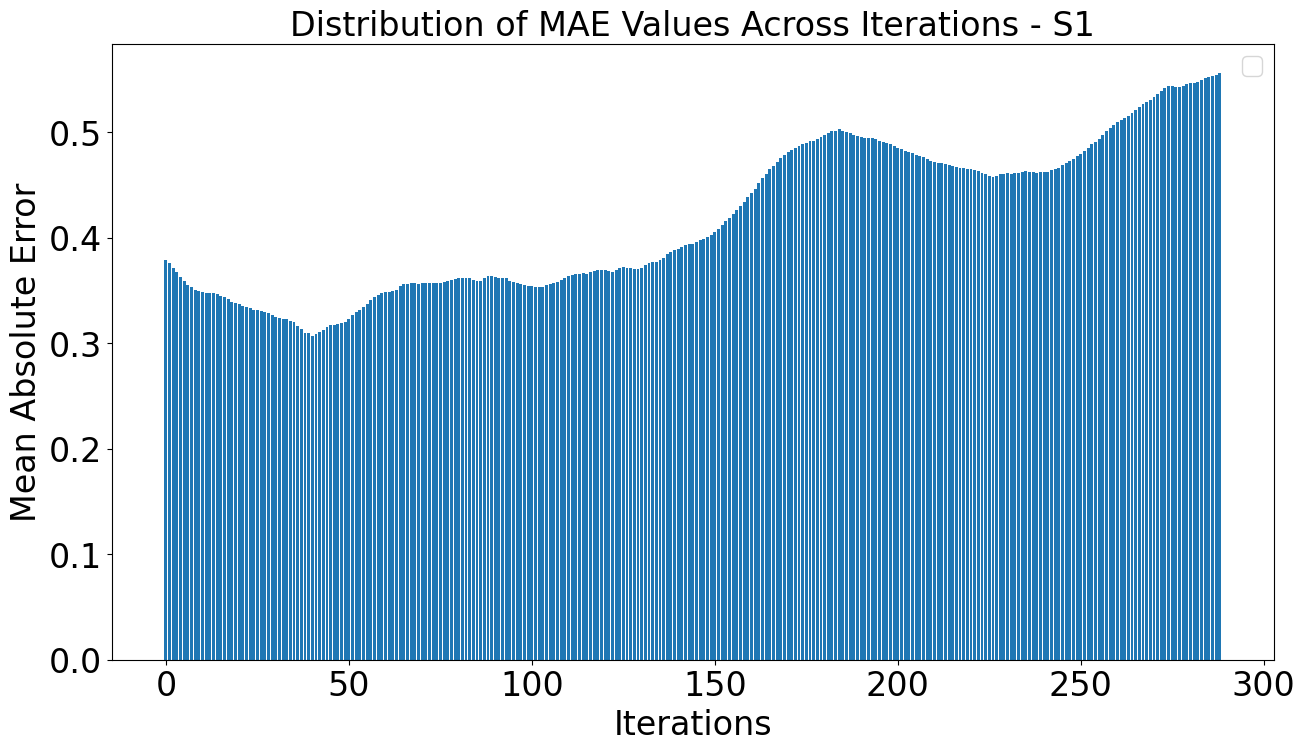

In [ ]:
a = pd.DataFrame(mae_l).reset_index()
a.columns = ['iterations', 'value']


# Set the font size for both the legend and axis numbers
legend_font_size = 18
axis_font_size = 24
k = 100
# Create a new figure object with a larger size and a higher DPI for better quality
fig = plt.figure(figsize=(15, 8), dpi=100)

# Create your plot within the new figure object
plt.bar(a['iterations'], a['value'])

# Add a legend to the plot with a larger font size
plt.legend(fontsize=legend_font_size)

# Increase the font size of the axis numbers
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)

# Add labels to the axes with a larger font size
plt.xlabel('Iterations', fontsize=axis_font_size)
plt.ylabel('Mean Absolute Error', fontsize=axis_font_size)
plt.title('Distribution of MAE Values Across Iterations - S1', fontsize = 24)


# Display the plot
plt.show()

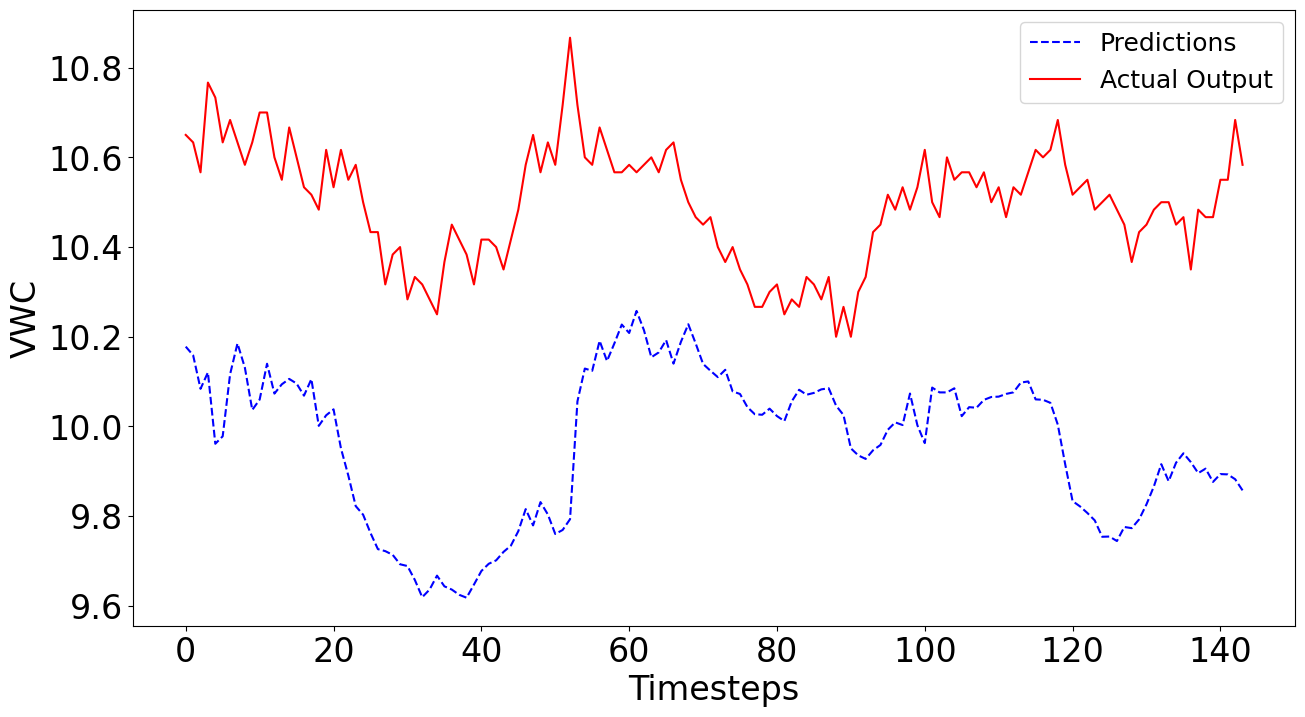

In [ ]:
import matplotlib.pyplot as plt

# Set the font size for both the legend and axis numbers
legend_font_size = 18
axis_font_size = 24
k = 270
# Create a new figure object with a larger size and a higher DPI for better quality
fig = plt.figure(figsize=(15, 8), dpi=100)

# Create your plot within the new figure object
plt.plot(pred[k], color = 'blue', label='Predictions', linestyle='--')
plt.plot(test_output_windows[k], color = 'red', label='Actual Output')

# Add a legend to the plot with a larger font size
plt.legend(fontsize=legend_font_size)

# Increase the font size of the axis numbers
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)

# Add labels to the axes with a larger font size
plt.xlabel('Timesteps', fontsize=axis_font_size)
plt.ylabel('VWC', fontsize=axis_font_size)

# Display the plot
plt.show()

**Test EEMD 123**

In [ ]:
dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])

data1 = pd.DataFrame(IMFs[0]).T
data2 = pd.DataFrame(IMFs[1]).T
data3 = pd.DataFrame(IMFs[2]).T

data = data1 + data2 + data3

data.columns = ['S7_Top_VWC_Avg','Rain','S7_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']

index = pd.DataFrame(dataset.index)

df = pd.concat([index, data], axis = 1)
df = df.set_index('Date Time')

from tensorflow.keras.models import load_model

# Assuming the best model was saved with filename 'best_model.h5'
moe_model = load_model('/content/drive/Shareddrives/1st Paper/best_MoE_model_S7_eemd123-0.h5')


df2 = df.copy()
scaler = StandardScaler()

# Fit and transform the data in the DataFrame
standardized_data = scaler.fit_transform(df2)

# Convert the result back to a DataFrame with the original column names
s_df = pd.DataFrame(standardized_data, columns=df2.columns)
train, test = split_dataset(df.values)
s_train, s_test = split_dataset(s_df.values)
#train = (train - np.mean(train, axis=0)) / np.std(train, axis=0)
test_input_windows, _ = to_supervised(s_test, 144)

_, test_output_windows = to_supervised(test, 144)
test_output_windows = np.array([[item] for item in test_output_windows[:][:]])
test_output_windows = test_output_windows.reshape(test_output_windows.shape[0],test_output_windows.shape[2], test_output_windows.shape[1])


pred = []
mae_l = []
mse_l = []
nmse_l = []
smape_l = []
i = 0
for window_idx in range(len(test_input_windows)):
  # Evaluate the model on the test data
  predictions = moe_model.predict(test_input_windows[window_idx], verbose = 0)
  pred.append(predictions)
  mae = mean_absolute_error(test_output_windows[i], predictions)
  mae_l.append(mae)
  mse = mean_squared_error(test_output_windows[i], predictions)
  mse_l.append(mse)
  nmse = nmse_loss(test_output_windows[i], predictions)
  nmse_l.append(nmse)
  smape = smape_loss(test_output_windows[i], predictions)
  smape_l.append(smape)
  i = i + 1

print('mae', np.mean(mae_l), 'mse', np.mean(mse_l), 'nmse',np.mean(nmse_l), 'smape', np.mean(smape_l))

mae 411.0635779579815 mse 744433.5515851242 nmse 347.59298027761344 smape 1.6324067


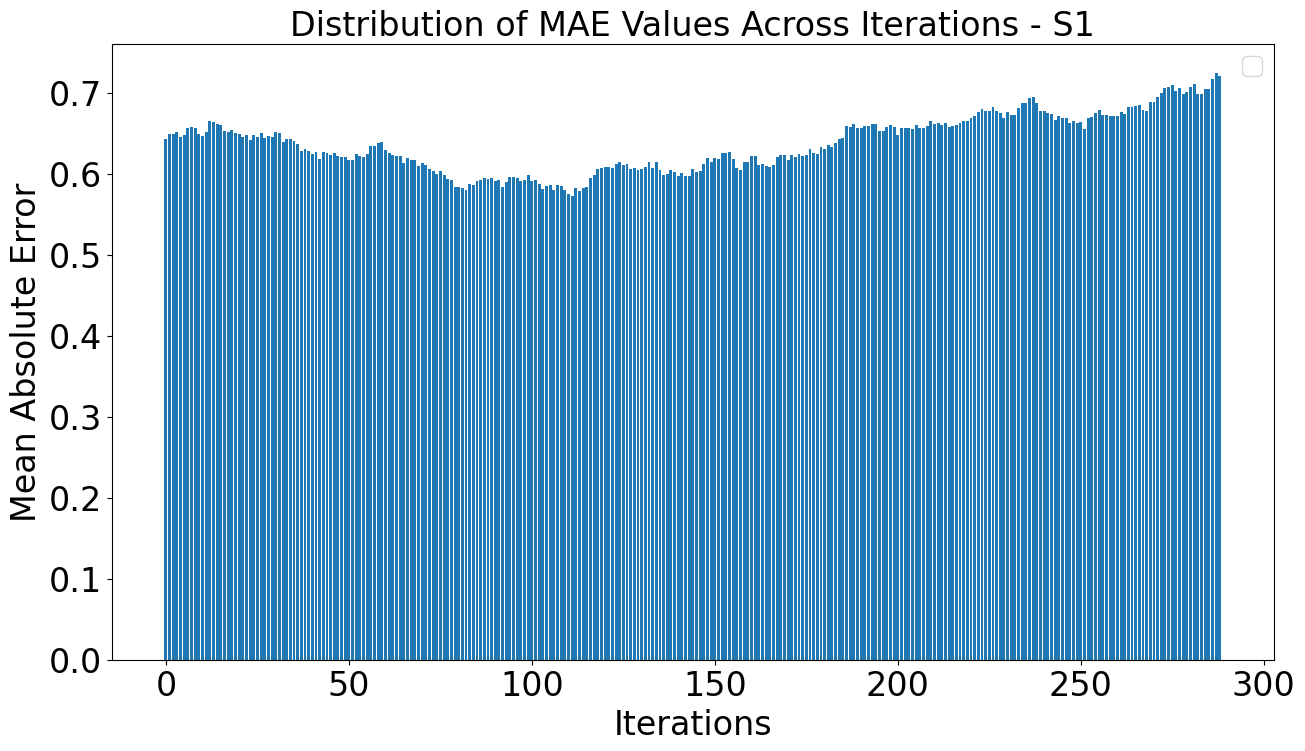

In [ ]:
a = pd.DataFrame(mae_l).reset_index()
a.columns = ['iterations', 'value']


# Set the font size for both the legend and axis numbers
legend_font_size = 18
axis_font_size = 24
k = 100
# Create a new figure object with a larger size and a higher DPI for better quality
fig = plt.figure(figsize=(15, 8), dpi=100)

# Create your plot within the new figure object
plt.line(a['iterations'], a['value'])

# Add a legend to the plot with a larger font size
plt.legend(fontsize=legend_font_size)

# Increase the font size of the axis numbers
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)

# Add labels to the axes with a larger font size
plt.xlabel('Iterations', fontsize=axis_font_size)
plt.ylabel('Mean Absolute Error', fontsize=axis_font_size)
plt.title('Distribution of MAE Values Across Iterations - S1', fontsize = 24)


# Display the plot
plt.show()

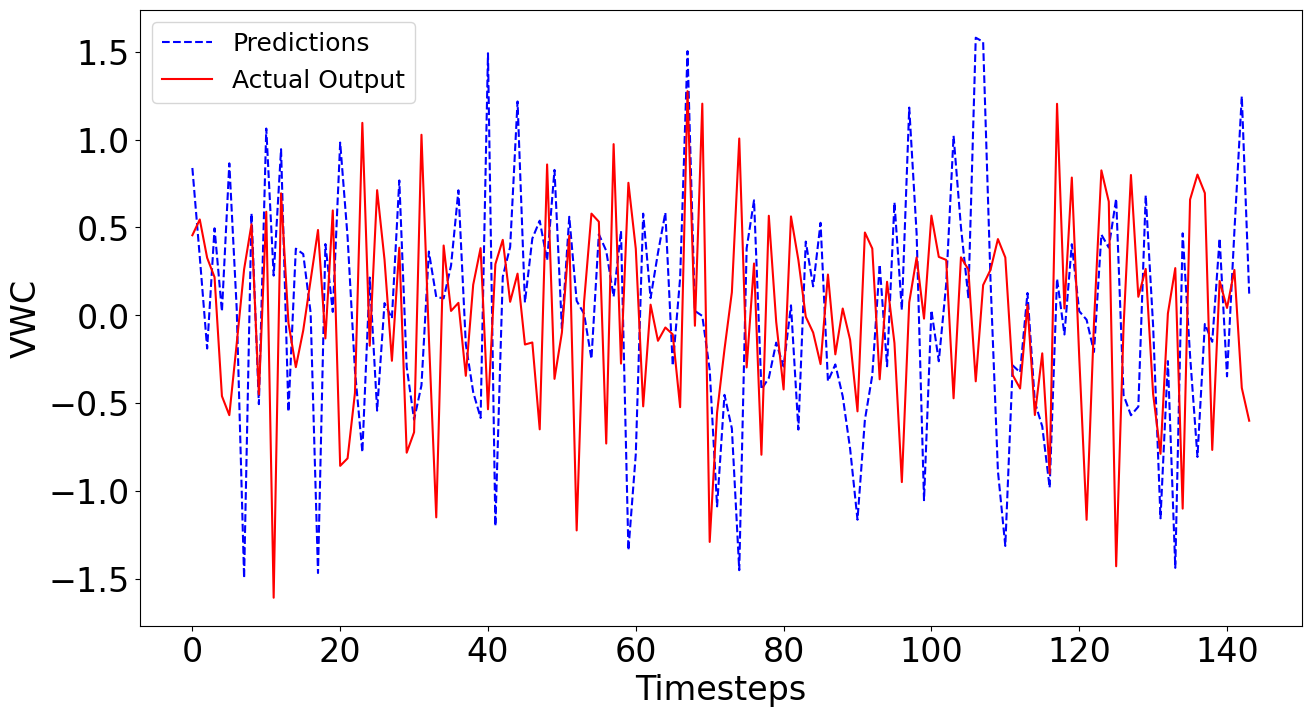

In [ ]:
import matplotlib.pyplot as plt

# Set the font size for both the legend and axis numbers
legend_font_size = 18
axis_font_size = 24
k = 270
# Create a new figure object with a larger size and a higher DPI for better quality
fig = plt.figure(figsize=(15, 8), dpi=100)

# Create your plot within the new figure object
plt.plot(pred[k], color = 'blue', label='Predictions', linestyle='--')
plt.plot(test_output_windows[k], color = 'red', label='Actual Output')

# Add a legend to the plot with a larger font size
plt.legend(fontsize=legend_font_size)

# Increase the font size of the axis numbers
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)

# Add labels to the axes with a larger font size
plt.xlabel('Timesteps', fontsize=axis_font_size)
plt.ylabel('VWC', fontsize=axis_font_size)

# Display the plot
plt.show()

**Test EEMD 456**

In [ ]:
dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])

data1 = pd.DataFrame(IMFs[4]).T
data2 = pd.DataFrame(IMFs[5]).T
data3 = pd.DataFrame(IMFs[6]).T

data = data1 + data2 + data3

data.columns = ['S7_Top_VWC_Avg','Rain','S7_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']

index = pd.DataFrame(dataset.index)

df = pd.concat([index, data], axis = 1)
df = df.set_index('Date Time')

from tensorflow.keras.models import load_model

# Assuming the best model was saved with filename 'best_model.h5'
moe_model = load_model('/content/drive/Shareddrives/1st Paper/best_MoE_model_S7_eemd456-_0.h5')


df2 = df.copy()
scaler = StandardScaler()

# Fit and transform the data in the DataFrame
standardized_data = scaler.fit_transform(df2)

# Convert the result back to a DataFrame with the original column names
s_df = pd.DataFrame(standardized_data, columns=df2.columns)
train, test = split_dataset(df.values)
s_train, s_test = split_dataset(s_df.values)
#train = (train - np.mean(train, axis=0)) / np.std(train, axis=0)
test_input_windows, _ = to_supervised(s_test, 144)

_, test_output_windows = to_supervised(test, 144)
test_output_windows = np.array([[item] for item in test_output_windows[:][:]])
test_output_windows = test_output_windows.reshape(test_output_windows.shape[0],test_output_windows.shape[2], test_output_windows.shape[1])


pred = []
mae_l = []
mse_l = []
nmse_l = []
smape_l = []
i = 0
for window_idx in range(len(test_input_windows)):
  # Evaluate the model on the test data
  predictions = moe_model.predict(test_input_windows[window_idx], verbose = 0)
  pred.append(predictions)
  mae = mean_absolute_error(test_output_windows[i], predictions)
  mae_l.append(mae)
  mse = mean_squared_error(test_output_windows[i], predictions)
  mse_l.append(mse)
  nmse = nmse_loss(test_output_windows[i], predictions)
  nmse_l.append(nmse)
  smape = smape_loss(test_output_windows[i], predictions)
  smape_l.append(smape)
  i = i + 1

print('mae', np.mean(mae_l), 'mse', np.mean(mse_l), 'nmse',np.mean(nmse_l), 'smape', np.mean(smape_l))

mae 0.13262890398906307 mse 0.03037817392821776 nmse 0.7731025120950484 smape 1.1034573


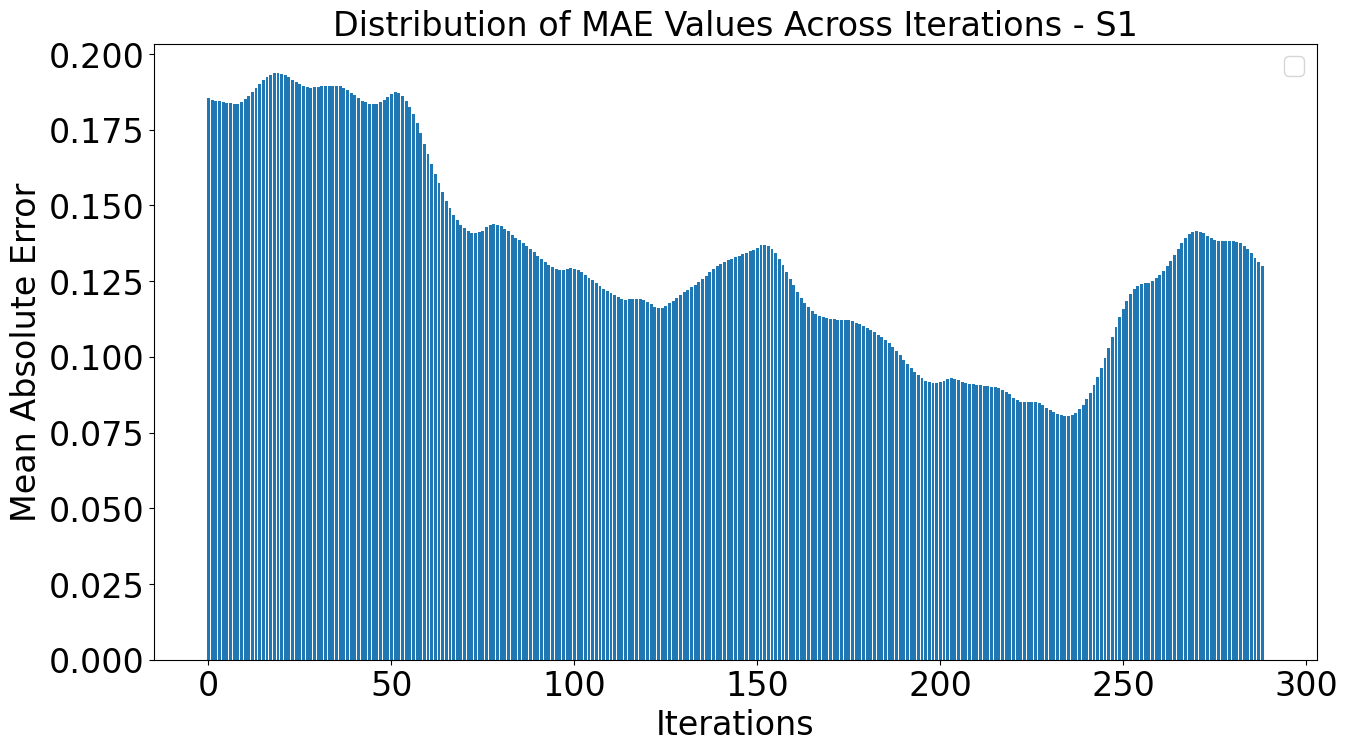

In [ ]:
a = pd.DataFrame(mae_l).reset_index()
a.columns = ['iterations', 'value']


# Set the font size for both the legend and axis numbers
legend_font_size = 18
axis_font_size = 24
k = 100
# Create a new figure object with a larger size and a higher DPI for better quality
fig = plt.figure(figsize=(15, 8), dpi=100)

# Create your plot within the new figure object
plt.bar(a['iterations'], a['value'])

# Add a legend to the plot with a larger font size
plt.legend(fontsize=legend_font_size)

# Increase the font size of the axis numbers
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)

# Add labels to the axes with a larger font size
plt.xlabel('Iterations', fontsize=axis_font_size)
plt.ylabel('Mean Absolute Error', fontsize=axis_font_size)
plt.title('Distribution of MAE Values Across Iterations - S1', fontsize = 24)


# Display the plot
plt.show()

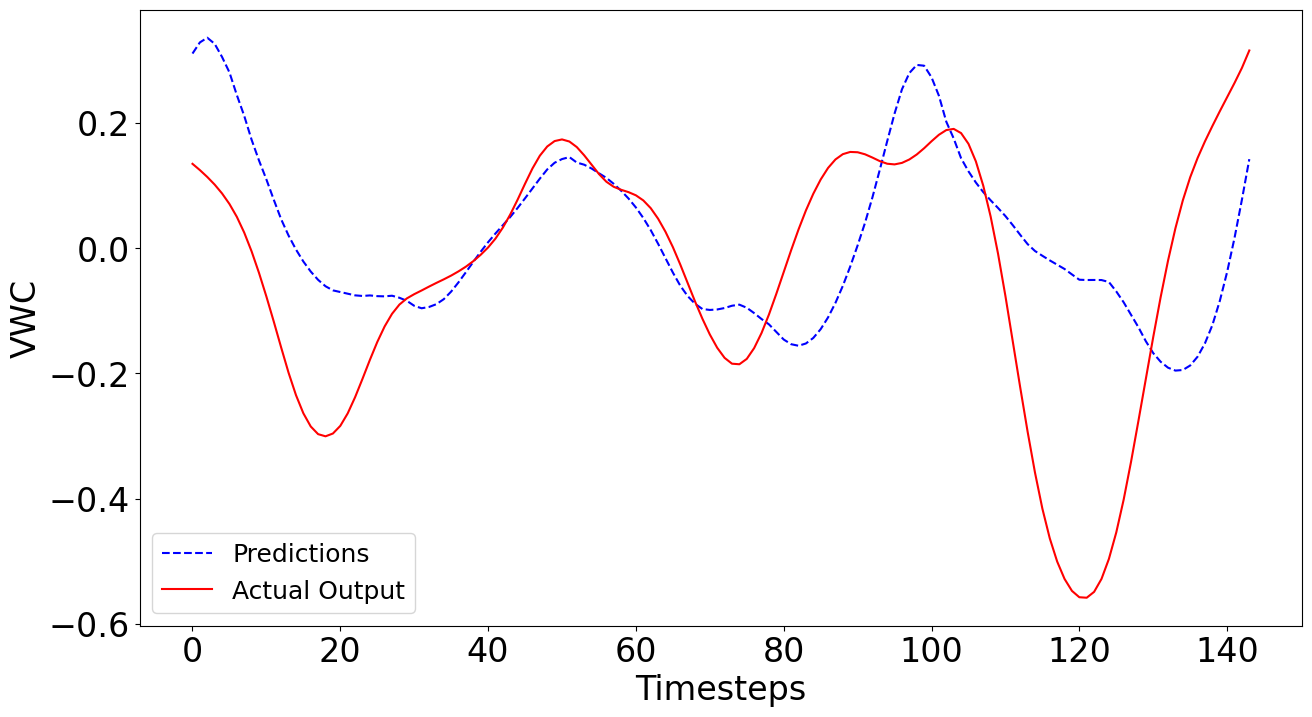

In [ ]:
import matplotlib.pyplot as plt

# Set the font size for both the legend and axis numbers
legend_font_size = 18
axis_font_size = 24
k = 270
# Create a new figure object with a larger size and a higher DPI for better quality
fig = plt.figure(figsize=(15, 8), dpi=100)

# Create your plot within the new figure object
plt.plot(pred[k], color = 'blue', label='Predictions', linestyle='--')
plt.plot(test_output_windows[k], color = 'red', label='Actual Output')

# Add a legend to the plot with a larger font size
plt.legend(fontsize=legend_font_size)

# Increase the font size of the axis numbers
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)

# Add labels to the axes with a larger font size
plt.xlabel('Timesteps', fontsize=axis_font_size)
plt.ylabel('VWC', fontsize=axis_font_size)

# Display the plot
plt.show()

**Test EEMD 789**

In [ ]:
dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])

data1 = pd.DataFrame(IMFs[7]).T
data2 = pd.DataFrame(IMFs[8]).T


data = data1 + data2

data.columns = ['S7_Top_VWC_Avg','Rain','S7_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']

index = pd.DataFrame(dataset.index)

df = pd.concat([index, data], axis = 1)
df = df.set_index('Date Time')

from tensorflow.keras.models import load_model

# Assuming the best model was saved with filename 'best_model.h5'
moe_model = load_model('/content/drive/Shareddrives/1st Paper/best_MoE_model_S7_eemd789-_0.h5')


df2 = df.copy()
scaler = StandardScaler()

# Fit and transform the data in the DataFrame
standardized_data = scaler.fit_transform(df2)

# Convert the result back to a DataFrame with the original column names
s_df = pd.DataFrame(standardized_data, columns=df2.columns)
train, test = split_dataset(df.values)
s_train, s_test = split_dataset(s_df.values)
#train = (train - np.mean(train, axis=0)) / np.std(train, axis=0)
test_input_windows, _ = to_supervised(s_test, 144)

_, test_output_windows = to_supervised(test, 144)
test_output_windows = np.array([[item] for item in test_output_windows[:][:]])
test_output_windows = test_output_windows.reshape(test_output_windows.shape[0],test_output_windows.shape[2], test_output_windows.shape[1])


pred = []
mae_l = []
mse_l = []
nmse_l = []
smape_l = []
i = 0
for window_idx in range(len(test_input_windows)):
  # Evaluate the model on the test data
  predictions = moe_model.predict(test_input_windows[window_idx], verbose = 0)
  pred.append(predictions)
  mae = mean_absolute_error(test_output_windows[i], predictions)
  mae_l.append(mae)
  mse = mean_squared_error(test_output_windows[i], predictions)
  mse_l.append(mse)
  nmse = nmse_loss(test_output_windows[i], predictions)
  nmse_l.append(nmse)
  smape = smape_loss(test_output_windows[i], predictions)
  smape_l.append(smape)
  i = i + 1

print('mae', np.mean(mae_l), 'mse', np.mean(mse_l), 'nmse',np.mean(nmse_l), 'smape', np.mean(smape_l))

mae 0.40055113435835366 mse 0.2149522742363154 nmse 9.828791507832142 smape 0.047237683


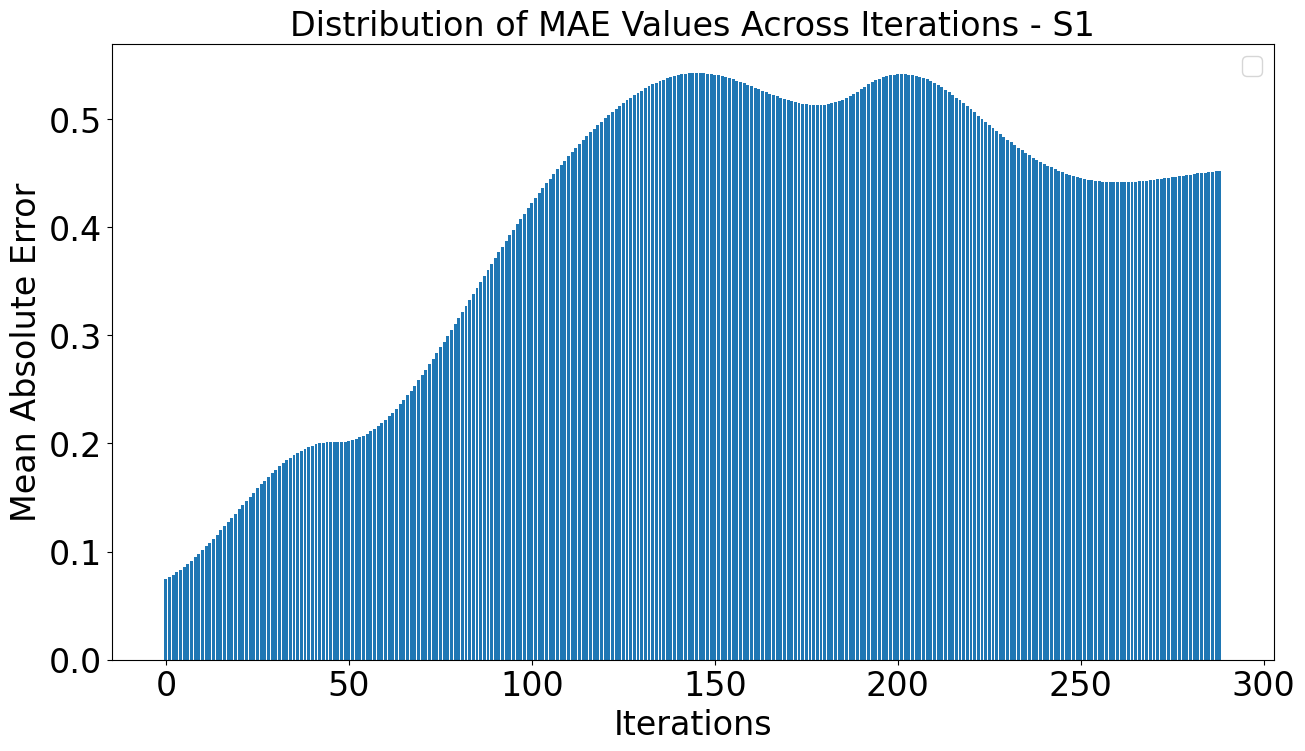

In [ ]:
a = pd.DataFrame(mae_l).reset_index()
a.columns = ['iterations', 'value']


# Set the font size for both the legend and axis numbers
legend_font_size = 18
axis_font_size = 24
k = 100
# Create a new figure object with a larger size and a higher DPI for better quality
fig = plt.figure(figsize=(15, 8), dpi=100)

# Create your plot within the new figure object
plt.bar(a['iterations'], a['value'])

# Add a legend to the plot with a larger font size
plt.legend(fontsize=legend_font_size)

# Increase the font size of the axis numbers
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)

# Add labels to the axes with a larger font size
plt.xlabel('Iterations', fontsize=axis_font_size)
plt.ylabel('Mean Absolute Error', fontsize=axis_font_size)
plt.title('Distribution of MAE Values Across Iterations - S1', fontsize = 24)


# Display the plot
plt.show()

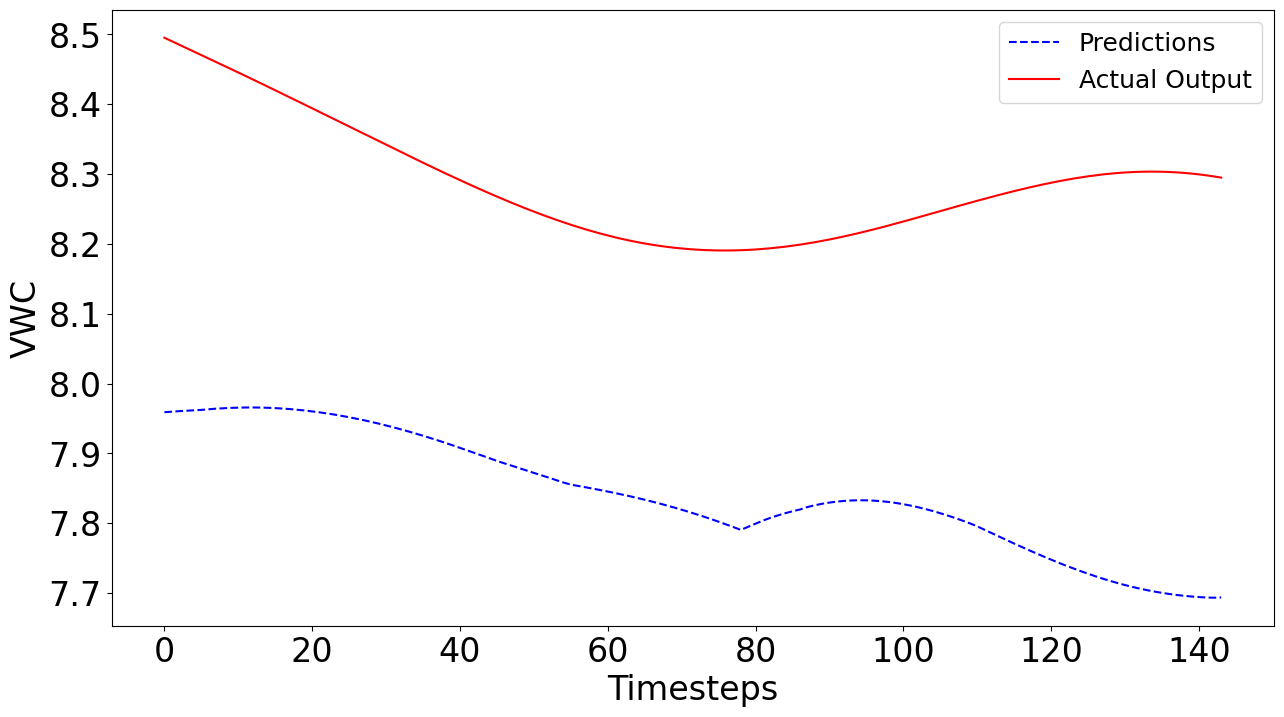

In [ ]:
import matplotlib.pyplot as plt

# Set the font size for both the legend and axis numbers
legend_font_size = 18
axis_font_size = 24
k = 270
# Create a new figure object with a larger size and a higher DPI for better quality
fig = plt.figure(figsize=(15, 8), dpi=100)

# Create your plot within the new figure object
plt.plot(pred[k], color = 'blue', label='Predictions', linestyle='--')
plt.plot(test_output_windows[k], color = 'red', label='Actual Output')

# Add a legend to the plot with a larger font size
plt.legend(fontsize=legend_font_size)

# Increase the font size of the axis numbers
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)

# Add labels to the axes with a larger font size
plt.xlabel('Timesteps', fontsize=axis_font_size)
plt.ylabel('VWC', fontsize=axis_font_size)

# Display the plot
plt.show()

**Individual models deployment**

In [7]:
dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])
dataset = dataset[['Rain','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']].reset_index()
s7 = pd.read_csv('/content/drive/Shareddrives/1st Paper/s7.csv', header = 0, infer_datetime_format=True, index_col=['TIMESTAMP']).drop('Unnamed: 0', axis=1).reset_index()

df = pd.concat([dataset, s7], axis = 1).set_index('Date Time')
df = df[['S7_Top_VWC_Avg','Rain','S7_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']]

In [10]:
def split_dataset(data):
  """
    Splits the dataset into train and test sets.

    Args:
        data (array): The dataset to be split.

    Returns:
        train (array): The training dataset.
        test (array): The testing dataset.
  """
  # split into standard weeks
  #train, test = data[1:6769], data[6769:6769+(144*8)]
  train, test = data[1:(2881+144*1)], data[(2881+144*1):(2881+144*1)+(144*8)]
  #train, test = data[:-5817], data[-5817:-57] 6048
  # restructure into windows of weekly data
  train = np.array(np.split(train, len(train)/144))
  test = np.array(np.split( test , len(test )/144))
  return train, test
df2 = df.copy()
scaler = StandardScaler()

# Fit and transform the data in the DataFrame
standardized_data = scaler.fit_transform(df2)

# Convert the result back to a DataFrame with the original column names
s_df = pd.DataFrame(standardized_data, columns=df2.columns)
train, test = split_dataset(df.values)
s_train, s_test = split_dataset(s_df.values)
#train = (train - np.mean(train, axis=0)) / np.std(train, axis=0)
test_input_windows, _ = to_supervised(s_test, 144)

_, test_output_windows = to_supervised(test, 144)
test_output_windows = np.array([[item] for item in test_output_windows[:][:]])
test_output_windows = test_output_windows.reshape(test_output_windows.shape[0],test_output_windows.shape[2], test_output_windows.shape[1])




In [ ]:
def save_best_e_model_callback(study, trial):
    if study.best_trial.number == trial.number:
        # Save the best model
        best_model = trial.user_attrs['model']
        model_path = f'/content/drive/Shareddrives/1st Paper/best_E_model_S7_{trial.number}.h5'
        best_model.save(model_path)
        print(f"Best model saved to {model_path}")

In [ ]:

from functools import partial


def create_train_expert_model(df, activation,
                              kernel_initializer, dropout_rate):

    df2 = df.copy()
    scaler = StandardScaler()

    # Fit and transform the data in the DataFrame
    standardized_data = scaler.fit_transform(df2)

    # Convert the result back to a DataFrame with the original column names
    s_df = pd.DataFrame(standardized_data, columns=df2.columns)
    train, test = split_dataset(df.values)
    s_train, s_test = split_dataset(s_df.values)
    #train = (train - np.mean(train, axis=0)) / np.std(train, axis=0)
    train_input_windows, _ = to_supervised(s_train, 144)

    _, train_output_windows = to_supervised(train, 144)
    train_output_windows = np.array([[item] for item in train_output_windows[:][:]])
    train_output_windows = train_output_windows.reshape(train_output_windows.shape[0],train_output_windows.shape[2], train_output_windows.shape[1])


    # Define the sizes of the hidden layers for each expert
    expert_hidden_sizes = [16, 32, 64]

    # Define the sizes of the output layers for each expert
    expert_output_sizes = [144,144,144]


    experts = []

    #if i == 0:  # Replace first expert with an autoencoder
    expert_input = Input(shape=(train_input_windows.shape[1], train_input_windows.shape[2]))
    expert_hidden = Dense(expert_hidden_sizes[0], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
    expert_hidden = Dropout(dropout_rate)(expert_hidden)
    #expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for LSTM input
    expert_hidden, _, _ = LSTM(expert_hidden_sizes[0], return_state=True, kernel_initializer='he_normal')(expert_hidden)
    attention = Dense(expert_hidden_sizes[0], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
    attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
    expert_hidden = Multiply()([expert_hidden, attention])
    expert_output = Dense(144, activation='linear', kernel_initializer='he_normal')(expert_hidden)
    expert_model = Model(inputs=expert_input, outputs=expert_output)
    #     experts.append(Model(inputs=expert_input, outputs=expert_output))
    # elif i == 1:  # Replace second expert with a Transformer expert
    #     expert_input = Input(shape=(train_input_windows.shape[1], train_input_windows.shape[2]))
    #     expert_hidden = Dense(expert_hidden_sizes[i], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
    #     expert_hidden = Dropout(dropout_rate)(expert_hidden)
    #     #expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for Transformer input
    #     expert_hidden = MultiHeadAttention(num_heads=8, key_dim=expert_hidden_sizes[i])(expert_hidden, expert_hidden)
    #     expert_hidden = Flatten()(expert_hidden)
    #     attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
    #     attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
    #     expert_hidden = Multiply()([expert_hidden, attention])
    #     expert_output = Dense(1, activation='linear', kernel_initializer='he_normal')(expert_hidden)
    #     experts.append(Model(inputs=expert_input, outputs=expert_output))
    # else:  # Replace third expert with a GRU-based model
    #     expert_input = Input(shape=(train_input_windows.shape[1], train_input_windows.shape[2]))
    #     expert_hidden = Dense(expert_hidden_sizes[i], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
    #     expert_hidden = Dropout(dropout_rate)(expert_hidden)
    #     #expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for GRU input
    #     expert_hidden, _ = GRU(expert_hidden_sizes[i], return_state=True, kernel_initializer='he_normal')(expert_hidden)
    #     attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
    #     attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
    #     expert_hidden = Multiply()([expert_hidden, attention])
    #     expert_output = Dense(1, activation='linear', kernel_initializer='he_normal')(expert_hidden)
    #     experts.append(Model(inputs=expert_input, outputs=expert_output))

    # Train each expert model
    #if i == 0:  # Autoencoder
    #expert_model = Model(inputs=experts[0].input, outputs=experts[0].output)
    # elif i == 1:  # CNN
    #     expert_model = Model(inputs=experts[1].input, outputs=experts[1].output)
    # else:  # Attention-based model
    #     expert_model = Model(inputs=experts[2].input, outputs=experts[2].output)

    expert_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_absolute_error', metrics=[mse_loss, nmse_loss, smape_loss])
    expert_model.fit(train_input_windows, train_output_windows, batch_size=32, epochs=100, verbose=0)

    return expert_model

def objective(trial):
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    kernel_initializer = trial.suggest_categorical('kernel_initializer', ['he_normal', 'lecun_normal'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    total_train_loss = 0
    total_val_loss = 0


    train, test = split_dataset(df.values)
    s_train, s_test = split_dataset(s_df.values)

    # split the training data into folds for walk-forward validation
    n_splits = 5
    fold_size = int(len(train) / n_splits)
    folds = [train[k:k+fold_size] for k in range(0, len(train), fold_size)]

    # build the model using the hyperparameters

    model =  create_train_expert_model(df, activation,
                              kernel_initializer, dropout_rate)

    # train and evaluate the model using walk-forward validation
    val_losses = []
    histories = []
    for fold_num in range(n_splits):
        # prepare data for this fold
        train_x, train_y = to_supervised(np.concatenate(folds[:fold_num] + folds[fold_num+1:]), 144)
        val_x, val_y = to_supervised(folds[fold_num], 144)
        train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
        val_y = val_y.reshape((val_y.shape[0], val_y.shape[1], 1))

        # train the model using early stopping
        es = EarlyStopping(monitor='val_loss', patience=10)
        history = model.fit(train_x, train_y, epochs=250, validation_data=(val_x, val_y), verbose=False, callbacks=[es])
        history = model.fit(train_x, train_y, epochs=250, validation_data=(val_x, val_y), verbose=False, callbacks=[es])
        histories.append(history.history)

        # evaluate the model on the validation set for this fold
        val_loss = history.history['val_loss'][-1]
        val_losses.append(val_loss)
    average_mse_loss = np.mean([h['mse_loss'][-1] for h in histories])
    print('average_mse_loss', average_mse_loss)

    average_val_mse_loss = np.mean([h['val_mse_loss'][-1] for h in histories])
    print('average_val_mse_loss',average_val_mse_loss)

    average_nmse_loss = np.mean([h['nmse_loss'][-1] for h in histories])
    print('average_nmse_loss', average_nmse_loss)

    average_val_nmse_loss = np.mean([h['val_nmse_loss'][-1] for h in histories])
    print('average_val_nmse_loss', average_val_nmse_loss)

    average_smape_loss = np.mean([h['smape_loss'][-1] for h in histories])
    print('average_smape_loss', average_smape_loss)
    average_val_smape_loss = np.mean([h['val_smape_loss'][-1] for h in histories])
    print('average_val_smape_loss', average_val_smape_loss)



    return np.mean(val_losses)


num_experts = 3
objective_with_args = partial(objective)
study = optuna.create_study(direction="minimize")

study.optimize(objective_with_args, n_trials=2) #change to 5


# retrieve the best hyperparameters
best_params = study.best_params
print('Best hyperparameters:', best_params)

df2 = df.copy()
scaler = StandardScaler()

# Fit and transform the data in the DataFrame
standardized_data = scaler.fit_transform(df2)

# Convert the result back to a DataFrame with the original column names
s_df = pd.DataFrame(standardized_data, columns=df2.columns)
train, test = split_dataset(df.values)
s_train, s_test = split_dataset(s_df.values)


# train the model using the best hyperparameters on the entire training set
model = create_train_expert_model( df, best_params['activation'], best_params['kernel_initializer'], best_params['dropout_rate'])



# set the filename based on the unique identifier
filename = f'/content/drive/Shareddrives/1st Paper/best_E_model_S7_i_zero.h5'



# save the model to a file
model.save(filename)

[I 2023-08-17 19:43:52,913] A new study created in memory with name: no-name-fefe0b2c-5136-46e7-a6f7-0c3869b0a0c5
[I 2023-08-17 19:46:10,764] Trial 0 finished with value: 1.9826211333274841 and parameters: {'activation': 'tanh', 'kernel_initializer': 'he_normal', 'dropout_rate': 0.40405439281119504}. Best is trial 0 with value: 1.9826211333274841.


average_mse_loss 3.2653529167175295
average_val_mse_loss 8.798302268981933
average_nmse_loss 0.494431746006012
average_val_nmse_loss 5.391094088554382
average_smape_loss 0.09682276993989944
average_val_smape_loss 0.18188078850507736


[I 2023-08-17 19:48:14,134] Trial 1 finished with value: 2.356434535980225 and parameters: {'activation': 'relu', 'kernel_initializer': 'lecun_normal', 'dropout_rate': 0.1536504040161015}. Best is trial 0 with value: 1.9826211333274841.


average_mse_loss 5.134830665588379
average_val_mse_loss 11.844864082336425
average_nmse_loss 0.7601356625556945
average_val_nmse_loss 6.759535264968872
average_smape_loss 0.13567588180303575
average_val_smape_loss 0.22276469320058823
Best hyperparameters: {'activation': 'tanh', 'kernel_initializer': 'he_normal', 'dropout_rate': 0.40405439281119504}


In [ ]:
from functools import partial


def create_train_expert_model(df, activation,
                              kernel_initializer, dropout_rate):

    df2 = df.copy()
    scaler = StandardScaler()

    # Fit and transform the data in the DataFrame
    standardized_data = scaler.fit_transform(df2)

    # Convert the result back to a DataFrame with the original column names
    s_df = pd.DataFrame(standardized_data, columns=df2.columns)
    train, test = split_dataset(df.values)
    s_train, s_test = split_dataset(s_df.values)
    #train = (train - np.mean(train, axis=0)) / np.std(train, axis=0)
    train_input_windows, _ = to_supervised(s_train, 144)

    _, train_output_windows = to_supervised(train, 144)
    train_output_windows = np.array([[item] for item in train_output_windows[:][:]])
    train_output_windows = train_output_windows.reshape(train_output_windows.shape[0],train_output_windows.shape[2], train_output_windows.shape[1])


    # Define the sizes of the hidden layers for each expert
    expert_hidden_sizes = [16, 32, 64]

    # Define the sizes of the output layers for each expert
    expert_output_sizes = [144,144,144]


    experts = []

    #if i == 0:  # Replace first expert with an autoencoder
    # expert_input = Input(shape=(train_input_windows.shape[1], train_input_windows.shape[2]))
    # expert_hidden = Dense(expert_hidden_sizes[0], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
    # expert_hidden = Dropout(dropout_rate)(expert_hidden)
    # #expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for LSTM input
    # expert_hidden, _, _ = LSTM(expert_hidden_sizes[0], return_state=True, kernel_initializer='he_normal')(expert_hidden)
    # attention = Dense(expert_hidden_sizes[0], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
    # attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
    # expert_hidden = Multiply()([expert_hidden, attention])
    # expert_output = Dense(1, activation='linear', kernel_initializer='he_normal')(expert_hidden)
    # expert_model = Model(inputs=expert_input, outputs=expert_output)
    #     experts.append(Model(inputs=expert_input, outputs=expert_output))
    # elif i == 1:  # Replace second expert with a Transformer expert
    expert_input = Input(shape=(train_input_windows.shape[1], train_input_windows.shape[2]))
    expert_hidden = Dense(expert_hidden_sizes[1], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
    expert_hidden = Dropout(dropout_rate)(expert_hidden)
    #expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for Transformer input
    expert_hidden = MultiHeadAttention(num_heads=8, key_dim=expert_hidden_sizes[1])(expert_hidden, expert_hidden)
    expert_hidden = Flatten()(expert_hidden)
    attention = Dense(expert_hidden_sizes[1], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
    attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
    expert_hidden = Multiply()([expert_hidden, attention])
    expert_output = Dense(144, activation='linear', kernel_initializer='he_normal')(expert_hidden)
    expert_model = Model(inputs=expert_input, outputs=expert_output)
    #     experts.append(Model(inputs=expert_input, outputs=expert_output))
    # else:  # Replace third expert with a GRU-based model
    #     expert_input = Input(shape=(train_input_windows.shape[1], train_input_windows.shape[2]))
    #     expert_hidden = Dense(expert_hidden_sizes[i], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
    #     expert_hidden = Dropout(dropout_rate)(expert_hidden)
    #     #expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for GRU input
    #     expert_hidden, _ = GRU(expert_hidden_sizes[i], return_state=True, kernel_initializer='he_normal')(expert_hidden)
    #     attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
    #     attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
    #     expert_hidden = Multiply()([expert_hidden, attention])
    #     expert_output = Dense(1, activation='linear', kernel_initializer='he_normal')(expert_hidden)
    #     experts.append(Model(inputs=expert_input, outputs=expert_output))

    # Train each expert model
    #if i == 0:  # Autoencoder
    #expert_model = Model(inputs=experts[0].input, outputs=experts[0].output)
    # elif i == 1:  # CNN
    #     expert_model = Model(inputs=experts[1].input, outputs=experts[1].output)
    # else:  # Attention-based model
    #     expert_model = Model(inputs=experts[2].input, outputs=experts[2].output)

    expert_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_absolute_error', metrics=[mae_loss, mse_loss, nmse_loss, smape_loss])
    expert_model.fit(train_input_windows, train_output_windows, batch_size=32, epochs=100, verbose=0)

    return expert_model

def objective(trial):
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    kernel_initializer = trial.suggest_categorical('kernel_initializer', ['he_normal', 'lecun_normal'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    total_train_loss = 0
    total_val_loss = 0


    train, test = split_dataset(df.values)
    s_train, s_test = split_dataset(s_df.values)

    # split the training data into folds for walk-forward validation
    n_splits = 5
    fold_size = int(len(train) / n_splits)
    folds = [train[k:k+fold_size] for k in range(0, len(train), fold_size)]

    # build the model using the hyperparameters

    model =  create_train_expert_model(df, activation,
                              kernel_initializer, dropout_rate)

    # train and evaluate the model using walk-forward validation
    val_losses = []
    histories = []
    for fold_num in range(n_splits):
        # prepare data for this fold
        train_x, train_y = to_supervised(np.concatenate(folds[:fold_num] + folds[fold_num+1:]), 144)
        val_x, val_y = to_supervised(folds[fold_num], 144)
        train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
        val_y = val_y.reshape((val_y.shape[0], val_y.shape[1], 1))

        # train the model using early stopping
        es = EarlyStopping(monitor='val_loss', patience=10)
        history = model.fit(train_x, train_y, epochs=250, validation_data=(val_x, val_y), verbose=False, callbacks=[es])
        history = model.fit(train_x, train_y, epochs=250, validation_data=(val_x, val_y), verbose=False, callbacks=[es])
        histories.append(history.history)

        # evaluate the model on the validation set for this fold
        val_loss = history.history['val_loss'][-1]
        val_losses.append(val_loss)

    average_mae_loss = np.mean([h['mae_loss'][-1] for h in histories])
    print('average_mae_loss', average_mae_loss)

    average_mse_loss = np.mean([h['mse_loss'][-1] for h in histories])
    print('average_mse_loss', average_mse_loss)

    average_val_mse_loss = np.mean([h['val_mse_loss'][-1] for h in histories])
    print('average_val_mse_loss',average_val_mse_loss)

    average_nmse_loss = np.mean([h['nmse_loss'][-1] for h in histories])
    print('average_nmse_loss', average_nmse_loss)

    average_val_nmse_loss = np.mean([h['val_nmse_loss'][-1] for h in histories])
    print('average_val_nmse_loss', average_val_nmse_loss)

    average_smape_loss = np.mean([h['smape_loss'][-1] for h in histories])
    print('average_smape_loss', average_smape_loss)
    average_val_smape_loss = np.mean([h['val_smape_loss'][-1] for h in histories])
    print('average_val_smape_loss', average_val_smape_loss)



    return np.mean(val_losses)


num_experts = 3
objective_with_args = partial(objective)
study = optuna.create_study(direction="minimize")

study.optimize(objective_with_args, n_trials=2) #change to 5


# retrieve the best hyperparameters
best_params = study.best_params
print('Best hyperparameters:', best_params)

df2 = df.copy()
scaler = StandardScaler()

# Fit and transform the data in the DataFrame
standardized_data = scaler.fit_transform(df2)

# Convert the result back to a DataFrame with the original column names
s_df = pd.DataFrame(standardized_data, columns=df2.columns)
train, test = split_dataset(df.values)
s_train, s_test = split_dataset(s_df.values)


# train the model using the best hyperparameters on the entire training set
model = create_train_expert_model( df, best_params['activation'], best_params['kernel_initializer'], best_params['dropout_rate'])



# set the filename based on the unique identifier
filename = f'/content/drive/Shareddrives/1st Paper/best_E_model_S7_i_one.h5'



# save the model to a file
model.save(filename)

[I 2023-08-17 19:49:08,209] A new study created in memory with name: no-name-8284405e-c445-4b06-97f7-6765dab232b4
[I 2023-08-17 19:51:02,304] Trial 0 finished with value: 1.4453928351402283 and parameters: {'activation': 'tanh', 'kernel_initializer': 'he_normal', 'dropout_rate': 0.2852980201613889}. Best is trial 0 with value: 1.4453928351402283.


average_mae_loss 0.5895297169685364
average_mse_loss 1.8395220041275024
average_val_mse_loss 6.600806879997253
average_nmse_loss 0.28175202906131747
average_val_nmse_loss 2.7525266885757445
average_smape_loss 0.057369860261678694
average_val_smape_loss 0.13370826616883277


[I 2023-08-17 19:52:49,916] Trial 1 finished with value: 1.6172489047050476 and parameters: {'activation': 'tanh', 'kernel_initializer': 'lecun_normal', 'dropout_rate': 0.14955264102635032}. Best is trial 0 with value: 1.4453928351402283.


average_mae_loss 0.5716192901134491
average_mse_loss 1.8159175872802735
average_val_mse_loss 7.402808308601379
average_nmse_loss 0.2754223674535751
average_val_nmse_loss 3.640682911872864
average_smape_loss 0.05528723150491714
average_val_smape_loss 0.14421599805355073
Best hyperparameters: {'activation': 'tanh', 'kernel_initializer': 'he_normal', 'dropout_rate': 0.2852980201613889}


In [ ]:
from functools import partial


def create_train_expert_model(df, activation,
                              kernel_initializer, dropout_rate):

    df2 = df.copy()
    scaler = StandardScaler()

    # Fit and transform the data in the DataFrame
    standardized_data = scaler.fit_transform(df2)

    # Convert the result back to a DataFrame with the original column names
    s_df = pd.DataFrame(standardized_data, columns=df2.columns)
    train, test = split_dataset(df.values)
    s_train, s_test = split_dataset(s_df.values)
    #train = (train - np.mean(train, axis=0)) / np.std(train, axis=0)
    train_input_windows, _ = to_supervised(s_train, 144)

    _, train_output_windows = to_supervised(train, 144)
    train_output_windows = np.array([[item] for item in train_output_windows[:][:]])
    train_output_windows = train_output_windows.reshape(train_output_windows.shape[0],train_output_windows.shape[2], train_output_windows.shape[1])


    # Define the sizes of the hidden layers for each expert
    expert_hidden_sizes = [16, 32, 64]

    # Define the sizes of the output layers for each expert
    expert_output_sizes = [144,144,144]


    experts = []

    #if i == 0:  # Replace first expert with an autoencoder
    # expert_input = Input(shape=(train_input_windows.shape[1], train_input_windows.shape[2]))
    # expert_hidden = Dense(expert_hidden_sizes[0], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
    # expert_hidden = Dropout(dropout_rate)(expert_hidden)
    # #expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for LSTM input
    # expert_hidden, _, _ = LSTM(expert_hidden_sizes[0], return_state=True, kernel_initializer='he_normal')(expert_hidden)
    # attention = Dense(expert_hidden_sizes[0], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
    # attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
    # expert_hidden = Multiply()([expert_hidden, attention])
    # expert_output = Dense(1, activation='linear', kernel_initializer='he_normal')(expert_hidden)
    # expert_model = Model(inputs=expert_input, outputs=expert_output)
    #     experts.append(Model(inputs=expert_input, outputs=expert_output))
    # elif i == 1:  # Replace second expert with a Transformer expert
    # expert_input = Input(shape=(train_input_windows.shape[1], train_input_windows.shape[2]))
    # expert_hidden = Dense(expert_hidden_sizes[2], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
    # expert_hidden = Dropout(dropout_rate)(expert_hidden)
    # #expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for Transformer input
    # expert_hidden = MultiHeadAttention(num_heads=8, key_dim=expert_hidden_sizes[1])(expert_hidden, expert_hidden)
    # expert_hidden = Flatten()(expert_hidden)
    # attention = Dense(expert_hidden_sizes[1], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
    # attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
    # expert_hidden = Multiply()([expert_hidden, attention])
    # expert_output = Dense(1, activation='linear', kernel_initializer='he_normal')(expert_hidden)
    # expert_model = Model(inputs=expert_input, outputs=expert_output)
    #     experts.append(Model(inputs=expert_input, outputs=expert_output))
    # else:  # Replace third expert with a GRU-based model
    expert_input = Input(shape=(train_input_windows.shape[1], train_input_windows.shape[2]))
    expert_hidden = Dense(expert_hidden_sizes[2], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
    expert_hidden = Dropout(dropout_rate)(expert_hidden)
    #expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for GRU input
    expert_hidden, _ = GRU(expert_hidden_sizes[2], return_state=True, kernel_initializer='he_normal')(expert_hidden)
    attention = Dense(expert_hidden_sizes[2], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
    attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
    expert_hidden = Multiply()([expert_hidden, attention])
    expert_output = Dense(144, activation='linear', kernel_initializer='he_normal')(expert_hidden)
    expert_model = Model(inputs=expert_input, outputs=expert_output)
    #     experts.append(Model(inputs=expert_input, outputs=expert_output))

    # Train each expert model
    #if i == 0:  # Autoencoder
    #expert_model = Model(inputs=experts[0].input, outputs=experts[0].output)
    # elif i == 1:  # CNN
    #     expert_model = Model(inputs=experts[1].input, outputs=experts[1].output)
    # else:  # Attention-based model
    #     expert_model = Model(inputs=experts[2].input, outputs=experts[2].output)

    expert_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_absolute_error', metrics=[mae_loss, mse_loss, nmse_loss, smape_loss])
    expert_model.fit(train_input_windows, train_output_windows, batch_size=32, epochs=100, verbose=0)

    return expert_model

def objective(trial):
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    kernel_initializer = trial.suggest_categorical('kernel_initializer', ['he_normal', 'lecun_normal'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    total_train_loss = 0
    total_val_loss = 0


    train, test = split_dataset(df.values)
    s_train, s_test = split_dataset(s_df.values)

    # split the training data into folds for walk-forward validation
    n_splits = 5
    fold_size = int(len(train) / n_splits)
    folds = [train[k:k+fold_size] for k in range(0, len(train), fold_size)]

    # build the model using the hyperparameters

    model =  create_train_expert_model(df, activation,
                              kernel_initializer, dropout_rate)

    # train and evaluate the model using walk-forward validation
    val_losses = []
    histories = []
    for fold_num in range(n_splits):
        # prepare data for this fold
        train_x, train_y = to_supervised(np.concatenate(folds[:fold_num] + folds[fold_num+1:]), 144)
        val_x, val_y = to_supervised(folds[fold_num], 144)
        train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
        val_y = val_y.reshape((val_y.shape[0], val_y.shape[1], 1))

        # train the model using early stopping
        es = EarlyStopping(monitor='val_loss', patience=10)
        history = model.fit(train_x, train_y, epochs=250, validation_data=(val_x, val_y), verbose=False, callbacks=[es])
        history = model.fit(train_x, train_y, epochs=250, validation_data=(val_x, val_y), verbose=False, callbacks=[es])
        histories.append(history.history)

        # evaluate the model on the validation set for this fold
        val_loss = history.history['val_loss'][-1]
        val_losses.append(val_loss)

    average_mae_loss = np.mean([h['mae_loss'][-1] for h in histories])
    print('average_mae_loss', average_mae_loss)

    average_mse_loss = np.mean([h['mse_loss'][-1] for h in histories])
    print('average_mse_loss', average_mse_loss)

    average_val_mse_loss = np.mean([h['val_mse_loss'][-1] for h in histories])
    print('average_val_mse_loss',average_val_mse_loss)

    average_nmse_loss = np.mean([h['nmse_loss'][-1] for h in histories])
    print('average_nmse_loss', average_nmse_loss)

    average_val_nmse_loss = np.mean([h['val_nmse_loss'][-1] for h in histories])
    print('average_val_nmse_loss', average_val_nmse_loss)

    average_smape_loss = np.mean([h['smape_loss'][-1] for h in histories])
    print('average_smape_loss', average_smape_loss)
    average_val_smape_loss = np.mean([h['val_smape_loss'][-1] for h in histories])
    print('average_val_smape_loss', average_val_smape_loss)



    return np.mean(val_losses)


num_experts = 3
objective_with_args = partial(objective)
study = optuna.create_study(direction="minimize")

study.optimize(objective_with_args, n_trials=2) #change to 5


# retrieve the best hyperparameters
best_params = study.best_params
print('Best hyperparameters:', best_params)

df2 = df.copy()
scaler = StandardScaler()

# Fit and transform the data in the DataFrame
standardized_data = scaler.fit_transform(df2)

# Convert the result back to a DataFrame with the original column names
s_df = pd.DataFrame(standardized_data, columns=df2.columns)
train, test = split_dataset(df.values)
s_train, s_test = split_dataset(s_df.values)


# train the model using the best hyperparameters on the entire training set
model = create_train_expert_model( df, best_params['activation'], best_params['kernel_initializer'], best_params['dropout_rate'])



# set the filename based on the unique identifier
filename = f'/content/drive/Shareddrives/1st Paper/best_E_model_S7_i_two.h5'



# save the model to a file
model.save(filename)

[I 2023-08-17 19:53:41,288] A new study created in memory with name: no-name-fefc1ce8-b8b9-4108-89c6-7831cc85ef0b
[I 2023-08-17 19:56:28,016] Trial 0 finished with value: 3.250408434867859 and parameters: {'activation': 'relu', 'kernel_initializer': 'lecun_normal', 'dropout_rate': 0.4826127538747771}. Best is trial 0 with value: 3.250408434867859.


average_mae_loss 1.2035956144332887
average_mse_loss 4.274867153167724
average_val_mse_loss 21.51485996246338
average_nmse_loss 0.6643725395202636
average_val_nmse_loss 14.342654991149903
average_smape_loss 0.11543100327253342
average_val_smape_loss 0.33296882808208467


[I 2023-08-17 19:58:32,481] Trial 1 finished with value: 1.195133125782013 and parameters: {'activation': 'tanh', 'kernel_initializer': 'lecun_normal', 'dropout_rate': 0.24943513552601934}. Best is trial 1 with value: 1.195133125782013.


average_mae_loss 0.6083946347236633
average_mse_loss 2.050204300880432
average_val_mse_loss 5.376772230863571
average_nmse_loss 0.3065588176250458
average_val_nmse_loss 1.7071483850479126
average_smape_loss 0.05893644839525223
average_val_smape_loss 0.10700471848249435
Best hyperparameters: {'activation': 'tanh', 'kernel_initializer': 'lecun_normal', 'dropout_rate': 0.24943513552601934}


In [8]:
def split_dataset(data):
  """
    Splits the dataset into train and test sets.

    Args:
        data (array): The dataset to be split.

    Returns:
        train (array): The training dataset.
        test (array): The testing dataset.
  """
  # split into standard weeks
  #train, test = data[1:6769], data[6769:6769+(144*8)]
  train, test = data[1:(2881+144*1)], data[(2881+144*1):(2881+144*1)+(144*8)]
  #train, test = data[:-5817], data[-5817:-57] 6048
  # restructure into windows of weekly data
  train = np.array(np.split(train, len(train)/144))
  test = np.array(np.split( test , len(test )/144))
  return train, test

In [11]:
from tensorflow.keras.models import load_model

# Define the custom metric/loss functions
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Load the model, including the custom objects
moe_model = load_model('/content/drive/Shareddrives/1st Paper/best_E_model_S7_i_zero.h5', custom_objects={'mse_loss': mse_loss, 'nmse_loss': nmse_loss, 'smape_loss': smape_loss})


df2 = df.copy()
scaler = StandardScaler()

# Fit and transform the data in the DataFrame
standardized_data = scaler.fit_transform(df2)

# Convert the result back to a DataFrame with the original column names
s_df = pd.DataFrame(standardized_data, columns=df2.columns)
train, test = split_dataset(df.values)
s_train, s_test = split_dataset(s_df.values)
#train = (train - np.mean(train, axis=0)) / np.std(train, axis=0)
train_input_windows, _ = to_supervised(s_train, 144)

_, train_output_windows = to_supervised(train, 144)
train_output_windows = np.array([[item] for item in train_output_windows[:][:]])
train_output_windows = train_output_windows.reshape(train_output_windows.shape[0],train_output_windows.shape[2], train_output_windows.shape[1])



pred = []
mae_l = []
mse_l = []
nmse_l = []
smape_l = []
for window_idx in range(len(test_input_windows)):
    window = np.expand_dims(test_input_windows[window_idx], axis=0)
    predictions = moe_model.predict(window, verbose=0)
    pred.append(predictions)
    mae = mean_absolute_error(test_output_windows[window_idx].ravel(), predictions.ravel())
    mae_l.append(mae)
    mse = mean_squared_error(test_output_windows[window_idx].ravel(), predictions.ravel())
    mse_l.append(mse)
    nmse = nmse_loss(test_output_windows[window_idx].ravel(), predictions.ravel())
    nmse_l.append(nmse)
    smape = smape_loss(test_output_windows[window_idx].ravel(), predictions.ravel())
    smape_l.append(smape)

print('mae', np.mean(mae_l), 'mse', np.mean(mse_l), 'nmse',np.mean(nmse_l), 'smape', np.mean(smape_l))

mae 1.4954617669271606 mse 3.374842609626314 nmse 7.638840156514525 smape 0.17252208


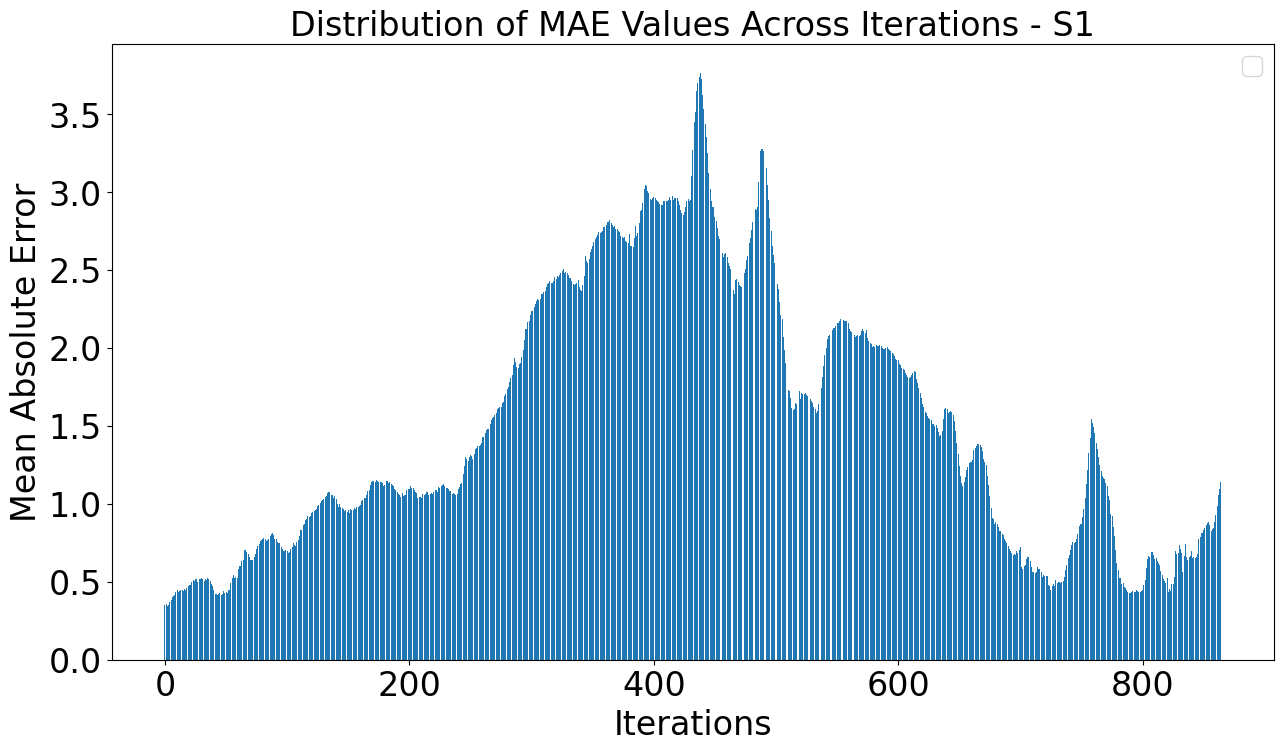

In [12]:

a = pd.DataFrame(mae_l).reset_index()
a.columns = ['iterations', 'value']
a.to_excel('/content/drive/Shareddrives/1st Paper/Results_MoE/TestS7E1.xlsx', index=False)

# Set the font size for both the legend and axis numbers
legend_font_size = 18
axis_font_size = 24
k = 100
# Create a new figure object with a larger size and a higher DPI for better quality
fig = plt.figure(figsize=(15, 8), dpi=100)

# Create your plot within the new figure object
plt.bar(range(len(mae_l)), mae_l)

# Add a legend to the plot with a larger font size
plt.legend(fontsize=legend_font_size)

# Increase the font size of the axis numbers
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)

# Add labels to the axes with a larger font size
plt.xlabel('Iterations', fontsize=axis_font_size)
plt.ylabel('Mean Absolute Error', fontsize=axis_font_size)
plt.title('Distribution of MAE Values Across Iterations - S1', fontsize = 24)


# Display the plot
plt.show()

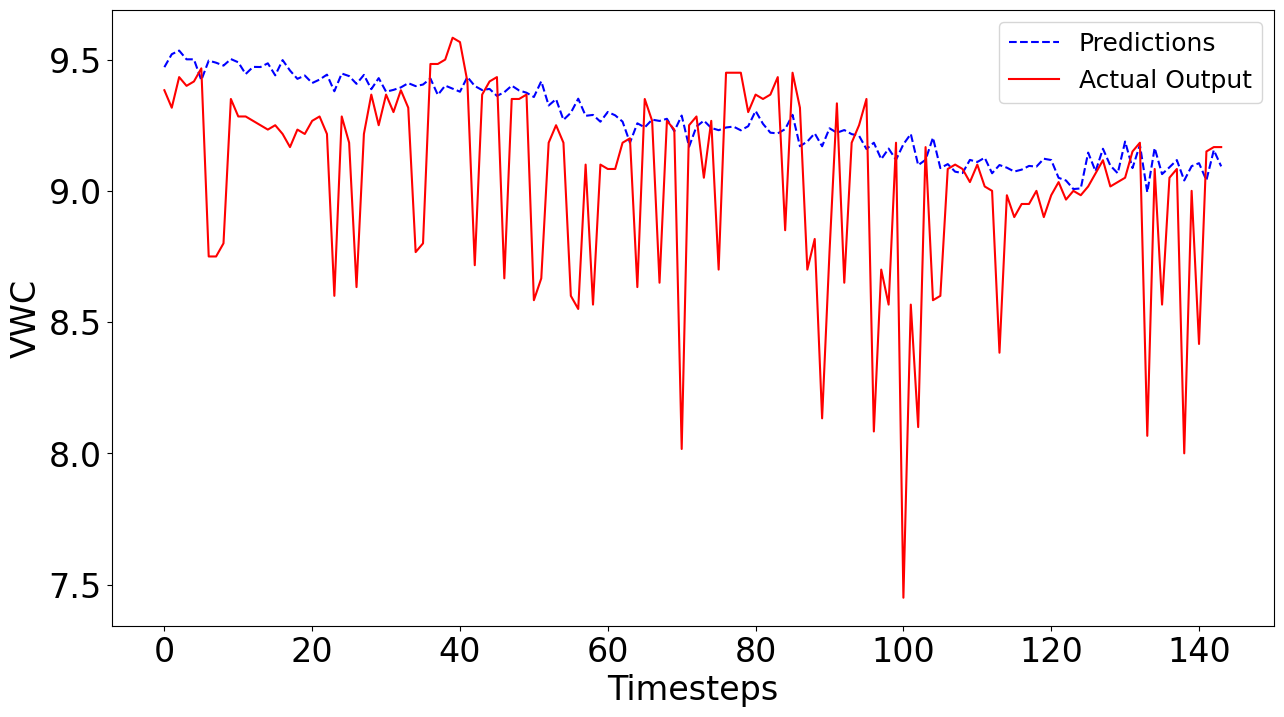

In [ ]:
import matplotlib.pyplot as plt

# Set the font size for both the legend and axis numbers
legend_font_size = 18
axis_font_size = 24
k = 100
# Create a new figure object with a larger size and a higher DPI for better quality
fig = plt.figure(figsize=(15, 8), dpi=100)

# Create your plot within the new figure object
plt.plot(pred[k][0], color = 'blue', label='Predictions', linestyle='--')
plt.plot(test_output_windows[k], color = 'red', label='Actual Output')

# Add a legend to the plot with a larger font size
plt.legend(fontsize=legend_font_size)

# Increase the font size of the axis numbers
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)

# Add labels to the axes with a larger font size
plt.xlabel('Timesteps', fontsize=axis_font_size)
plt.ylabel('VWC', fontsize=axis_font_size)

# Display the plot
plt.show()

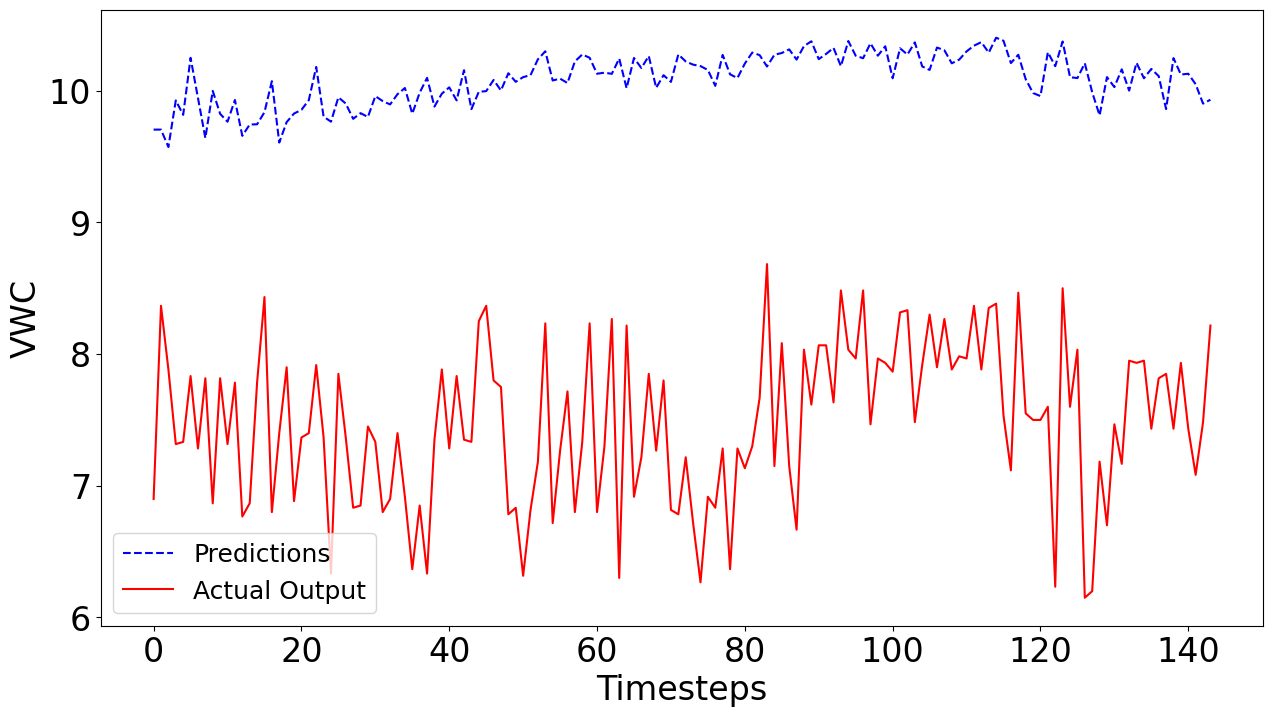

In [ ]:
import matplotlib.pyplot as plt

# Set the font size for both the legend and axis numbers
legend_font_size = 18
axis_font_size = 24
k = 600
# Create a new figure object with a larger size and a higher DPI for better quality
fig = plt.figure(figsize=(15, 8), dpi=100)

# Create your plot within the new figure object
plt.plot(pred[k][0], color = 'blue', label='Predictions', linestyle='--')
plt.plot(test_output_windows[k], color = 'red', label='Actual Output')

# Add a legend to the plot with a larger font size
plt.legend(fontsize=legend_font_size)

# Increase the font size of the axis numbers
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)

# Add labels to the axes with a larger font size
plt.xlabel('Timesteps', fontsize=axis_font_size)
plt.ylabel('VWC', fontsize=axis_font_size)

# Display the plot
plt.show()

In [13]:
from tensorflow.keras.models import load_model

# Define the custom metric/loss functions
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Load the model, including the custom objects
moe_model = load_model('/content/drive/Shareddrives/1st Paper/best_E_model_S7_i_one.h5', custom_objects={'mae_loss': mae_loss,'mse_loss': mse_loss, 'nmse_loss': nmse_loss, 'smape_loss': smape_loss})


df2 = df.copy()
scaler = StandardScaler()

# Fit and transform the data in the DataFrame
standardized_data = scaler.fit_transform(df2)

# Convert the result back to a DataFrame with the original column names
s_df = pd.DataFrame(standardized_data, columns=df2.columns)
train, test = split_dataset(df.values)
s_train, s_test = split_dataset(s_df.values)
#train = (train - np.mean(train, axis=0)) / np.std(train, axis=0)
train_input_windows, _ = to_supervised(s_train, 144)

_, train_output_windows = to_supervised(train, 144)
train_output_windows = np.array([[item] for item in train_output_windows[:][:]])
train_output_windows = train_output_windows.reshape(train_output_windows.shape[0],train_output_windows.shape[2], train_output_windows.shape[1])



pred = []
mae_l = []
mse_l = []
nmse_l = []
smape_l = []
for window_idx in range(len(test_input_windows)):
    window = np.expand_dims(test_input_windows[window_idx], axis=0)
    predictions = moe_model.predict(window, verbose=0)
    pred.append(predictions)
    mae = mean_absolute_error(test_output_windows[window_idx].ravel(), predictions.ravel())
    mae_l.append(mae)
    mse = mean_squared_error(test_output_windows[window_idx].ravel(), predictions.ravel())
    mse_l.append(mse)
    nmse = nmse_loss(test_output_windows[window_idx].ravel(), predictions.ravel())
    nmse_l.append(nmse)
    smape = smape_loss(test_output_windows[window_idx].ravel(), predictions.ravel())
    smape_l.append(smape)

print('mae', np.mean(mae_l), 'mse', np.mean(mse_l), 'nmse',np.mean(nmse_l), 'smape', np.mean(smape_l))

mae 1.2513376773818166 mse 2.4034667815660544 nmse 6.218838301577732 smape 0.14874645


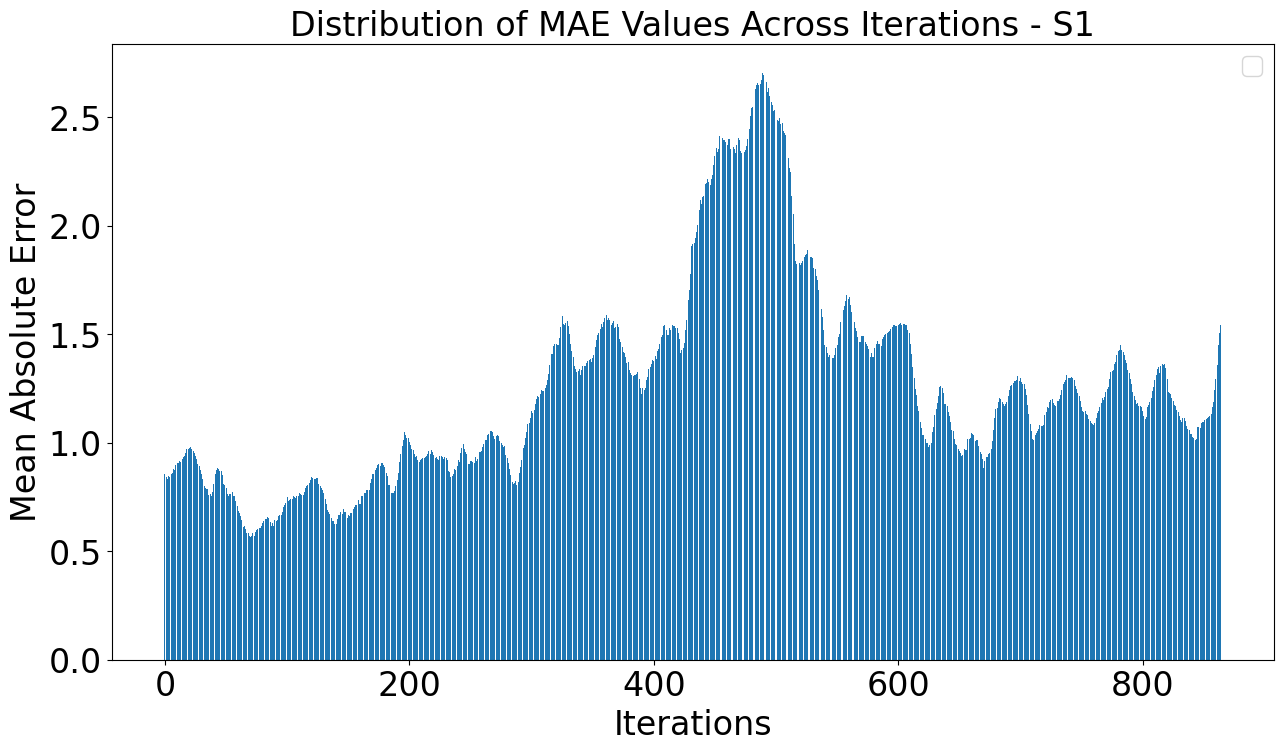

In [14]:

a = pd.DataFrame(mae_l).reset_index()
a.columns = ['iterations', 'value']
a.to_excel('/content/drive/Shareddrives/1st Paper/Results_MoE/TestS7E2.xlsx', index=False)

# Set the font size for both the legend and axis numbers
legend_font_size = 18
axis_font_size = 24
k = 100
# Create a new figure object with a larger size and a higher DPI for better quality
fig = plt.figure(figsize=(15, 8), dpi=100)

# Create your plot within the new figure object
plt.bar(range(len(mae_l)), mae_l)

# Add a legend to the plot with a larger font size
plt.legend(fontsize=legend_font_size)

# Increase the font size of the axis numbers
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)

# Add labels to the axes with a larger font size
plt.xlabel('Iterations', fontsize=axis_font_size)
plt.ylabel('Mean Absolute Error', fontsize=axis_font_size)
plt.title('Distribution of MAE Values Across Iterations - S1', fontsize = 24)


# Display the plot
plt.show()

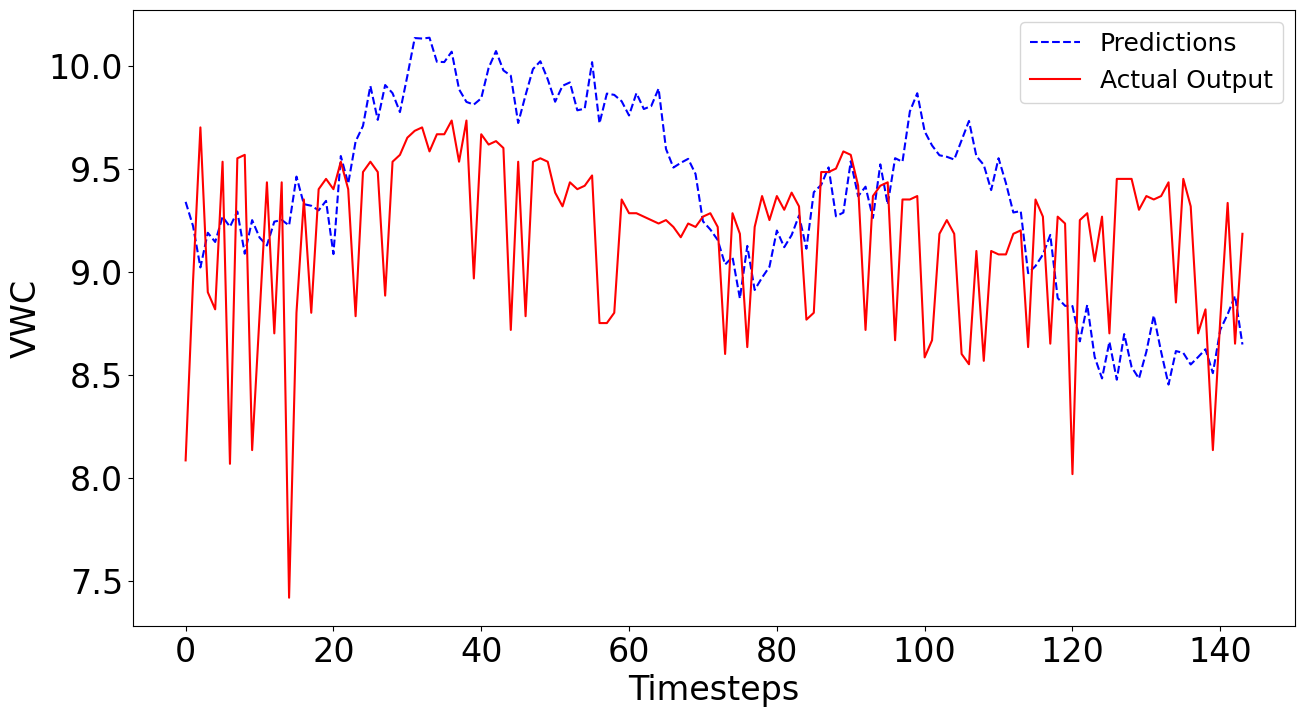

In [ ]:
import matplotlib.pyplot as plt

# Set the font size for both the legend and axis numbers
legend_font_size = 18
axis_font_size = 24
k = 50

# Create a new figure object with a larger size and a higher DPI for better quality
fig = plt.figure(figsize=(15, 8), dpi=100)

# Create your plot within the new figure object
plt.plot(pred[k][0], color = 'blue', label='Predictions', linestyle='--')
plt.plot(test_output_windows[k], color = 'red', label='Actual Output')

# Add a legend to the plot with a larger font size
plt.legend(fontsize=legend_font_size)

# Increase the font size of the axis numbers
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)

# Add labels to the axes with a larger font size
plt.xlabel('Timesteps', fontsize=axis_font_size)
plt.ylabel('VWC', fontsize=axis_font_size)

# Display the plot
plt.show()

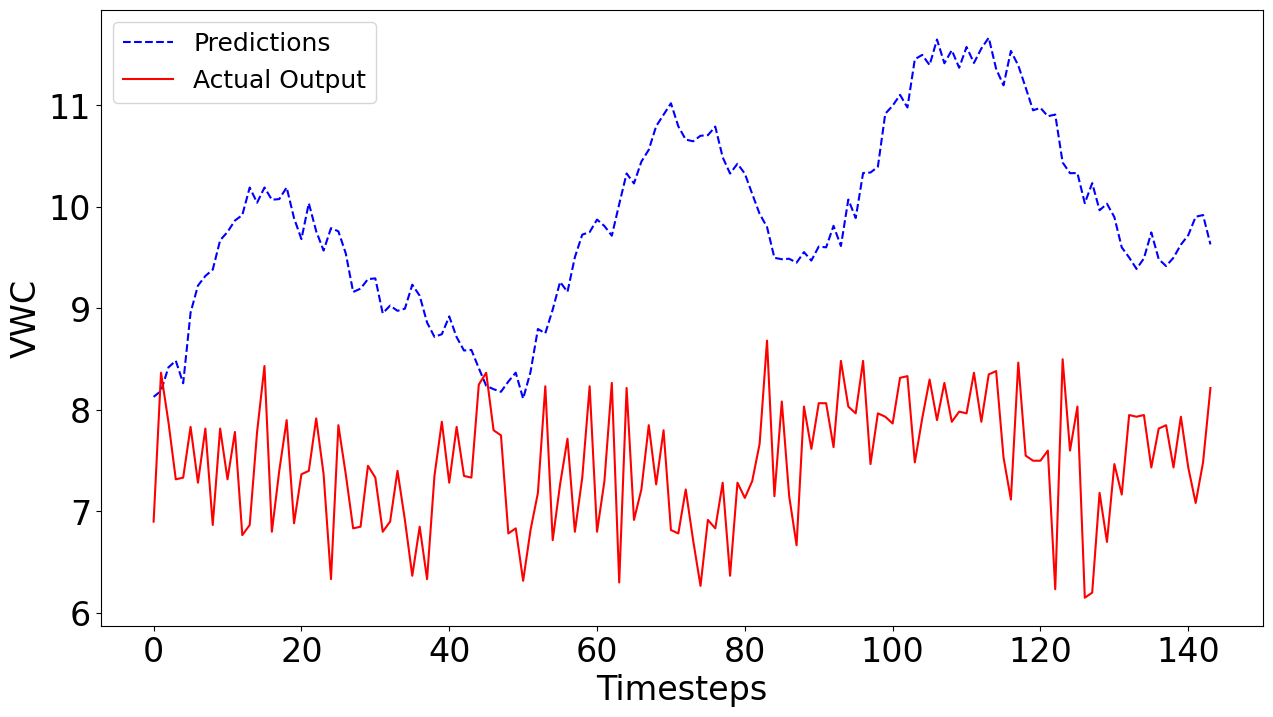

In [ ]:
import matplotlib.pyplot as plt

# Set the font size for both the legend and axis numbers
legend_font_size = 18
axis_font_size = 24
k = 600
# Create a new figure object with a larger size and a higher DPI for better quality
fig = plt.figure(figsize=(15, 8), dpi=100)

# Create your plot within the new figure object
plt.plot(pred[k][0], color = 'blue', label='Predictions', linestyle='--')
plt.plot(test_output_windows[k], color = 'red', label='Actual Output')

# Add a legend to the plot with a larger font size
plt.legend(fontsize=legend_font_size)

# Increase the font size of the axis numbers
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)

# Add labels to the axes with a larger font size
plt.xlabel('Timesteps', fontsize=axis_font_size)
plt.ylabel('VWC', fontsize=axis_font_size)

# Display the plot
plt.show()

In [ ]:
pred[0]

In [15]:
from tensorflow.keras.models import load_model

# Define the custom metric/loss functions
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Load the model, including the custom objects
moe_model = load_model('/content/drive/Shareddrives/1st Paper/best_E_model_S7_i_two.h5', custom_objects={'mae_loss': mae_loss,'mse_loss': mse_loss, 'nmse_loss': nmse_loss, 'smape_loss': smape_loss})


df2 = df.copy()
scaler = StandardScaler()

# Fit and transform the data in the DataFrame
standardized_data = scaler.fit_transform(df2)

# Convert the result back to a DataFrame with the original column names
s_df = pd.DataFrame(standardized_data, columns=df2.columns)
train, test = split_dataset(df.values)
s_train, s_test = split_dataset(s_df.values)
#train = (train - np.mean(train, axis=0)) / np.std(train, axis=0)
train_input_windows, _ = to_supervised(s_train, 144)

_, train_output_windows = to_supervised(train, 144)
train_output_windows = np.array([[item] for item in train_output_windows[:][:]])
train_output_windows = train_output_windows.reshape(train_output_windows.shape[0],train_output_windows.shape[2], train_output_windows.shape[1])



pred = []
mae_l = []
mse_l = []
nmse_l = []
smape_l = []
for window_idx in range(len(test_input_windows)):
    window = np.expand_dims(test_input_windows[window_idx], axis=0)
    predictions = moe_model.predict(window, verbose=0)
    pred.append(predictions)
    mae = mean_absolute_error(test_output_windows[window_idx].ravel(), predictions.ravel())
    mae_l.append(mae)
    mse = mean_squared_error(test_output_windows[window_idx].ravel(), predictions.ravel())
    mse_l.append(mse)
    nmse = nmse_loss(test_output_windows[window_idx].ravel(), predictions.ravel())
    nmse_l.append(nmse)
    smape = smape_loss(test_output_windows[window_idx].ravel(), predictions.ravel())
    smape_l.append(smape)

print('mae', np.mean(mae_l), 'mse', np.mean(mse_l), 'nmse',np.mean(nmse_l), 'smape', np.mean(smape_l))

mae 1.2108543495730615 mse 2.2321130468596704 nmse 5.072785449057172 smape 0.1421927


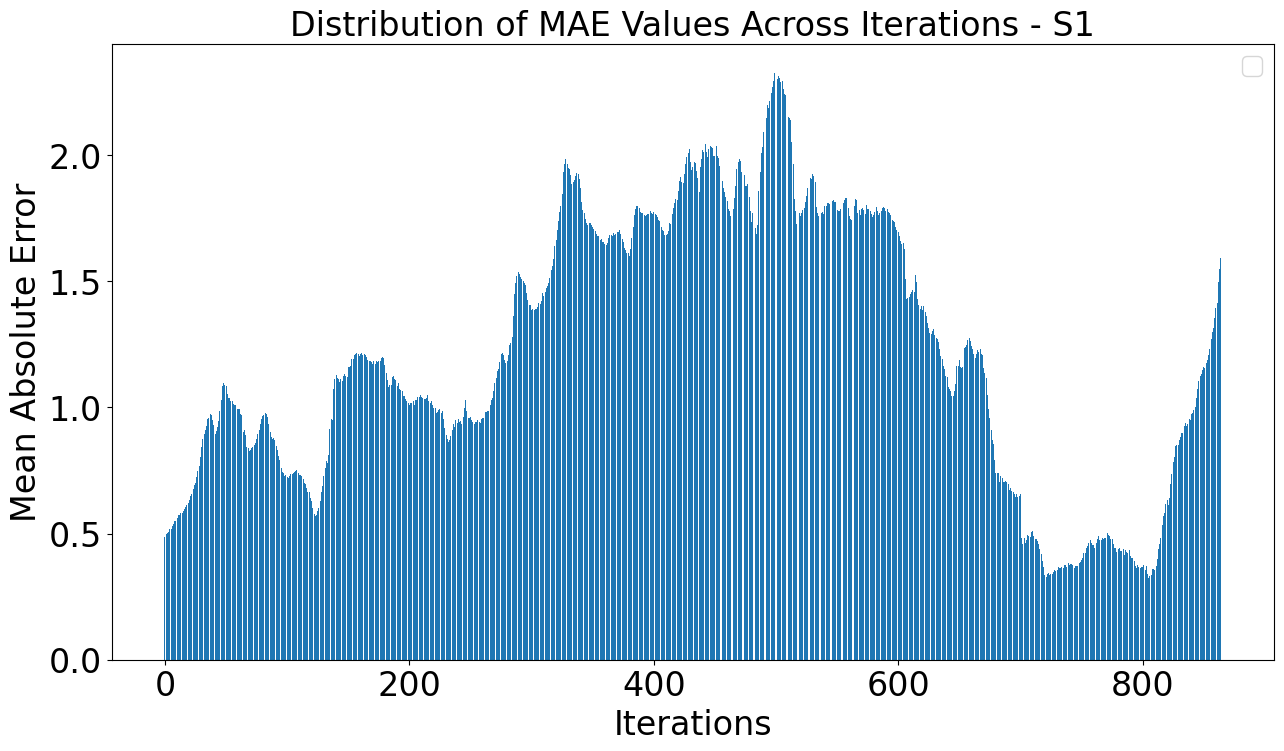

In [16]:

a = pd.DataFrame(mae_l).reset_index()
a.columns = ['iterations', 'value']
a.to_excel('/content/drive/Shareddrives/1st Paper/Results_MoE/TestS7E3.xlsx', index=False)

# Set the font size for both the legend and axis numbers
legend_font_size = 18
axis_font_size = 24
k = 100
# Create a new figure object with a larger size and a higher DPI for better quality
fig = plt.figure(figsize=(15, 8), dpi=100)

# Create your plot within the new figure object
plt.bar(range(len(mae_l)), mae_l)

# Add a legend to the plot with a larger font size
plt.legend(fontsize=legend_font_size)

# Increase the font size of the axis numbers
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)

# Add labels to the axes with a larger font size
plt.xlabel('Iterations', fontsize=axis_font_size)
plt.ylabel('Mean Absolute Error', fontsize=axis_font_size)
plt.title('Distribution of MAE Values Across Iterations - S1', fontsize = 24)


# Display the plot
plt.show()

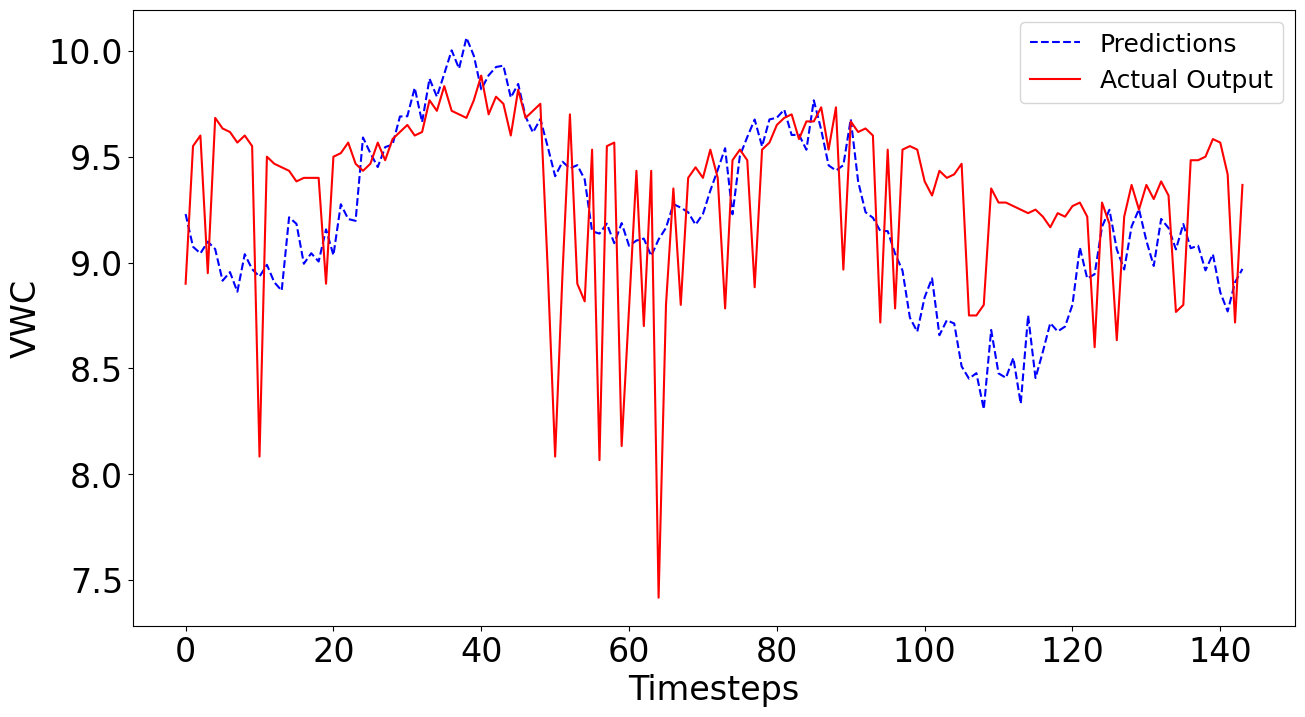

In [ ]:
import matplotlib.pyplot as plt

# Set the font size for both the legend and axis numbers
legend_font_size = 18
axis_font_size = 24
k = 0
# Create a new figure object with a larger size and a higher DPI for better quality
fig = plt.figure(figsize=(15, 8), dpi=100)

# Create your plot within the new figure object
plt.plot(pred[k][0], color = 'blue', label='Predictions', linestyle='--')
plt.plot(test_output_windows[k], color = 'red', label='Actual Output')

# Add a legend to the plot with a larger font size
plt.legend(fontsize=legend_font_size)

# Increase the font size of the axis numbers
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)

# Add labels to the axes with a larger font size
plt.xlabel('Timesteps', fontsize=axis_font_size)
plt.ylabel('VWC', fontsize=axis_font_size)

# Display the plot
plt.show()

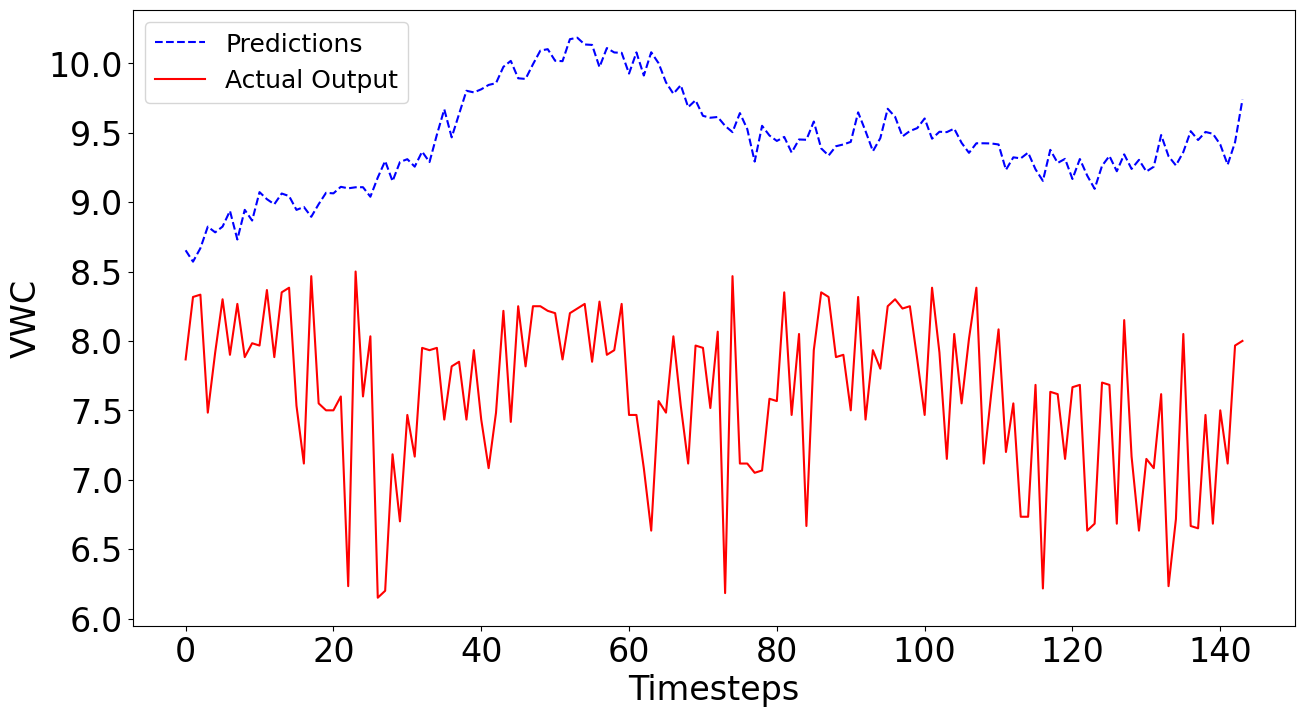

In [ ]:
import matplotlib.pyplot as plt

# Set the font size for both the legend and axis numbers
legend_font_size = 18
axis_font_size = 24
k = 700
# Create a new figure object with a larger size and a higher DPI for better quality
fig = plt.figure(figsize=(15, 8), dpi=100)

# Create your plot within the new figure object
plt.plot(pred[k][0], color = 'blue', label='Predictions', linestyle='--')
plt.plot(test_output_windows[k], color = 'red', label='Actual Output')

# Add a legend to the plot with a larger font size
plt.legend(fontsize=legend_font_size)

# Increase the font size of the axis numbers
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)

# Add labels to the axes with a larger font size
plt.xlabel('Timesteps', fontsize=axis_font_size)
plt.ylabel('VWC', fontsize=axis_font_size)

# Display the plot
plt.show()